# Utilities

In [10]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import pi
from scipy import integrate
import cartopy.crs as ccrs
import h5py
import cartopy.io.img_tiles as cimgt
from scipy.constants import h, c, k
import scipy
from matplotlib import colors
from matplotlib import cm
from os import listdir
from os.path import isfile, join
import subprocess
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from jupyterthemes import jtplot
import matplotlib as mpl
import imageio
from IPython.display import Image
from scipy import interpolate
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sympy import symbols, solve,  Eq
import scipy.stats as stats
import matplotlib.font_manager
k_b=k
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from recursive_diff import recursive_diff


In [11]:
mpl.rcdefaults() 
jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')
fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

In [12]:
labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)']

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [14]:
def get_fsi_reference_data(ds, act_px, alt_px):
    z = ds['Z'][:][:,act_px, alt_px]
    Tskin = ds['Tskin'][:][act_px, alt_px]
    T = ds['temperature'][:][:,act_px, alt_px]
    p = ds['pressure'][:][:,act_px, alt_px]
    
    h2o = ds['h2o'][:][:,act_px, alt_px]
    co2 = ds['co2'][:]
    o3 = ds['o3'][:]
    gases= [h2o,co2,o3]
    
    
    
    CL_top = ds['CL_top'][:][:,act_px, alt_px][0]
    CL_thick = ds['CL_thick'][:][:,act_px, alt_px][0]
    CL_OD = ds['CL_OD'][:][:,act_px, alt_px][0]
    CL_Re = ds['CL_Re'][:][:,act_px, alt_px][0]
    cloud_data = [CL_top, CL_thick, CL_OD, CL_Re]
    
    return z, Tskin, T, p, gases, cloud_data

In [15]:
deg_to_rad = pi/180
earth_max_radius = 6378.137 #km
earth_min_radius = 6356.752 #km
angular_speed_of_earth = 2*pi/(86400*1.002737904)
gravity0_0 = 9.80616e-3
gravity0_2 = 0.0026373
gravity0_4 = 0.0000059

In [16]:
def pwv(z, p, x, lat): # height in m, pressure levels in Pa, h2o profile, latitude in degrees
    x[np.isnan(x)]=0
    p[np.isnan(p)]=0
    idc = np.where(p!=0)
    x = x[idc]
    p = p[idc]
    z = z[idc]
    y = x/gravity(lat,z)
#     pwv = (-integrate.simps(y,p))/997
    pwv2 = (-integrate.trapz(y,p))/997
    return pwv2*1000

In [17]:
def gravity(lat, z): # z in m, latitude in degrees
    lat_rad = lat*deg_to_rad
    z = z/1000 # change z to km
    local_radius = earth_max_radius**2/np.sqrt(earth_max_radius**2-(earth_max_radius**2-earth_min_radius**2)*np.sin(lat_rad)**2)
    x = local_radius*np.cos(lat_rad)
    y = (earth_min_radius**2/earth_max_radius**2)*local_radius*np.sin(lat_rad)
    d = np.sqrt(x**2+y**2)
    g_0 = gravity0_0*(1-gravity0_2*np.cos(2*lat_rad)+gravity0_4*np.cos(2*lat_rad)**2)
    g_0 = g_0 + angular_speed_of_earth**2*local_radius**2*np.cos(lat_rad)**2/d
    g = (g_0*(d/(d+z))**2- angular_speed_of_earth**2*local_radius*np.cos(lat_rad)**2*(local_radius+z)/d)*1000 
    # changed back to m/s^2
    return g

# Intro

## Huang emissivities

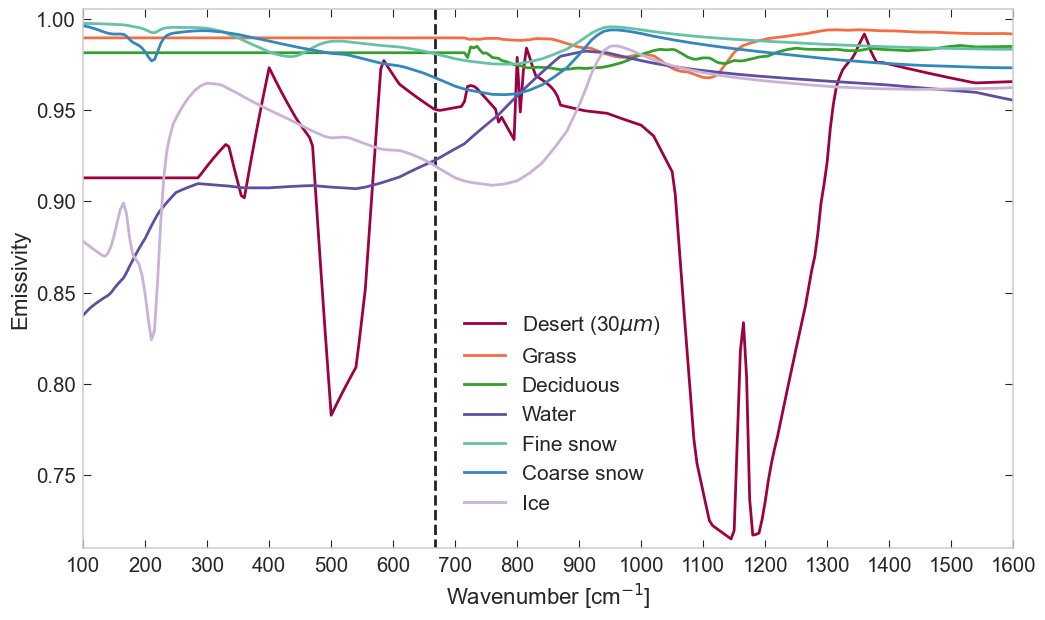

In [18]:
types = ['Desert (30$\mu m$)','45% desert and 55% grass','Grass','Dry grass','Deciduous','Conifer','Water','Fine snow','Medium snow','Coarse snow','Ice']
color_list = ['#9e0142','#f46d43','#33a02c','#5e4fa2','#66c2a5','#3288bd','#cab2d6']
fig = plt.figure(figsize=(12,7))
for idc, i in enumerate([1,3,5,7,8,10,11]):
    f = 'EMISS/EMISSIVITY_{}'.format(i)
    dset = pd.read_csv(f, header=None, sep=' ', skipinitialspace=True, skiprows=1, names=['emiss', 'wn'])
    plt.plot(dset['wn'],dset['emiss'], label=types[i-1], color=color_list[idc],linewidth=2)
plt.xlabel('Wavenumber [cm$^{-1}$]',fontsize=16)
plt.ylabel('Emissivity',fontsize=16)
plt.xticks(np.arange(100,1700,100))
plt.xlim(left=100,right=1600)
plt.ylim(0.71,1.005)
plt.vlines(667,0.5,1.2,linestyle='--',color='k',linewidth=2)
plt.legend(bbox_to_anchor=(0.4, 0.05), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
plt.grid(True)
fig.patch.set_alpha(1)
plt.grid(False)
fig.savefig('plots/fig01.pdf',bbox_inches='tight')
plt.show()

## Noise

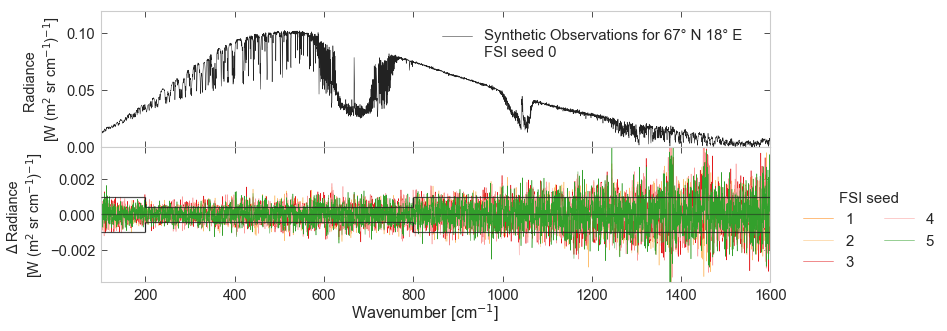

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(12,5))
case1 = '6718'
color_list =['#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00'][::-1]
ax = fig.add_subplot(211)
ds_fsi1 = nc.Dataset('OUTPUTS/SGM/EM_{}_4iseed/fe2es_fsi_out_d0001.nc'.format(case1))
ax.plot(ds_fsi1['sigma'][:],ds_fsi1['avg_spe'][:],linewidth=0.5,alpha=1,color='k',label='\nSynthetic Observations for 67° N 18° E \nFSI seed 0')
ax.set_ylabel('Radiance \n[W (m$^2$ sr cm$^{-1}$)$^{-1}$]')
ax.set_ylim(0,0.12)
ax.legend(bbox_to_anchor=(0.5, 0.6), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax = fig.add_subplot(212,sharex=ax)

for i, case2 in enumerate(['{}_{}iseed'.format(case1,i) for i in np.arange(4,9)]):
    ds_fsi1 = nc.Dataset('OUTPUTS/SGM/EM_{}_4iseed/fe2es_fsi_out_d0001.nc'.format(case1))
    ds_fsi2 = nc.Dataset('OUTPUTS/SGM/EM_{}/fe2es_fsi_out_d0001.nc'.format(case2))
    diff = ds_fsi1['avg_spe'][:]-ds_fsi2['avg_spe'][:]
    wn = ds_fsi1['sigma']
    bins = np.arange(120,1575,5)
    digitized = np.digitize(wn, bins)
    wn_binned = np.array([wn[digitized == i].mean() for i in range(1, len(bins))])
    bin_means = np.array([diff[digitized == i].mean() for i in range(1, len(bins))])
#     ax.plot(wn_binned,bin_means)
    ax.plot(wn,diff,linewidth=0.5,alpha=1,label='{}'.format(i+1),color=color_list[i])

yline = np.array([1,0.4,1])
xline1 = np.array([100,200,800])
xline2 = np.array([200,800,1600])
lg = plt.legend(bbox_to_anchor=(1.04, 0.05), loc='lower left', borderaxespad=0., ncol=2,fontsize=15,fancybox=False,frameon=False,title='FSI seed')
lg.get_title().set_fontsize(15)
ax.hlines(yline/1000,xline1,xline2,color='k', zorder=10,alpha=0.8)
ax.hlines(-yline/1000,xline1,xline2,color='k', zorder=10,alpha=0.8)
ax.vlines([200,800],-1/1000,-0.4/1000,color='k',zorder=100)
ax.vlines([200,800],0.4/1000,1/1000,color='k',zorder=100)
ax.hlines(0,100,1600,color='k',zorder=20,alpha=0.5)
ax.set_xlim(right=1600, left=100)
ax.set_ylim(-0.0038,0.0038)
ax.set_ylabel('Δ Radiance \n[W (m$^2$ sr cm$^{-1}$)$^{-1}$]')
ax.grid(False)
fig.supxlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize)
fig.subplots_adjust(hspace=0)
fig.savefig('plots/fig02.pdf',bbox_inches='tight')
plt.show()

# Product and quantifiers

## Quantifiers

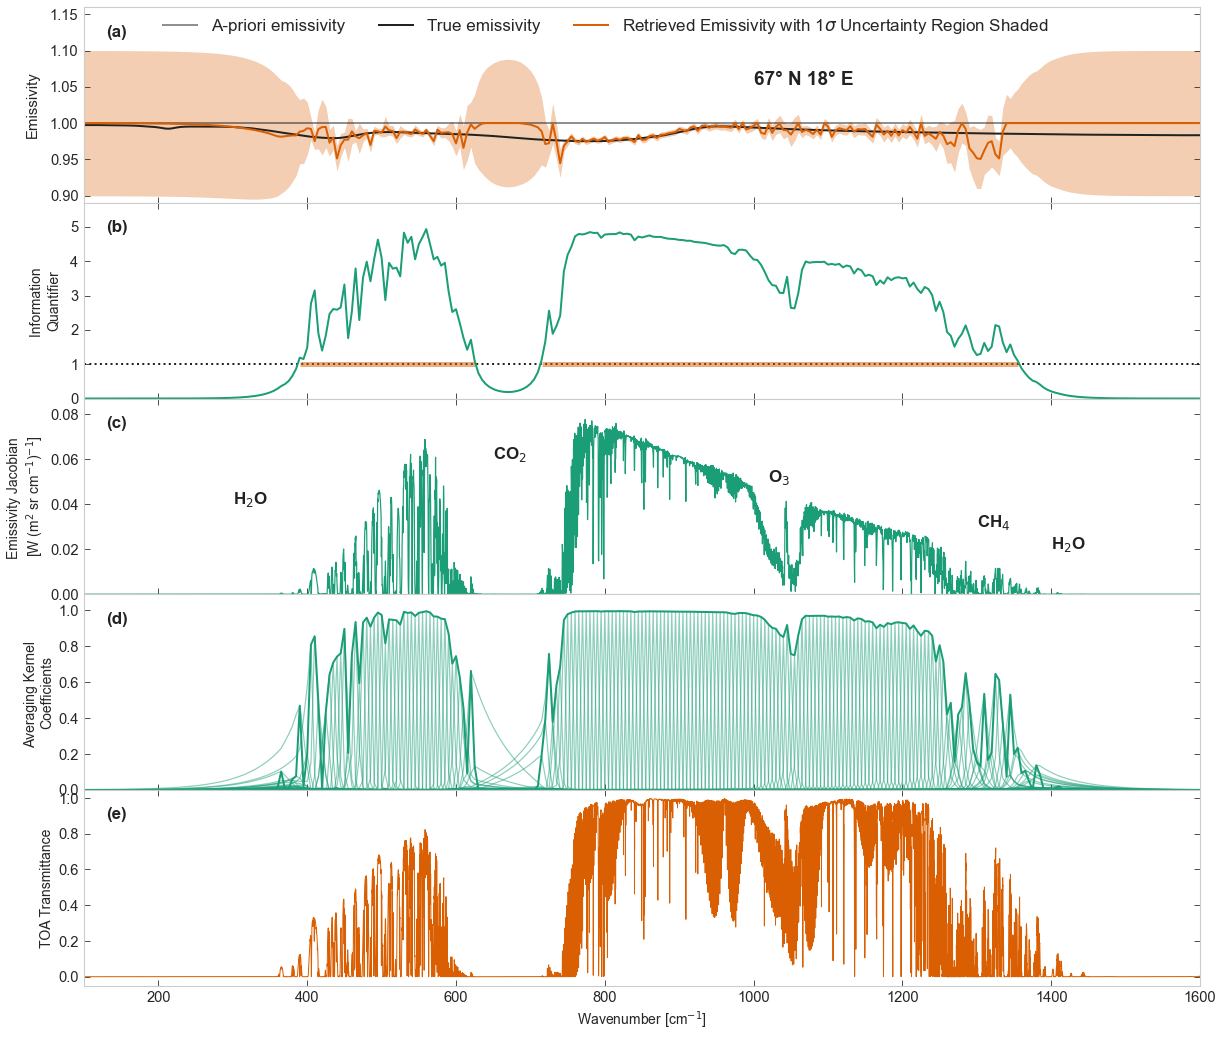

In [20]:
ds_trans = nc.Dataset('OUTPUTS/transmisttance_results/fe2es_sgm_ref_transmittance67N_18E.nc')
%matplotlib inline
color_list = ['#1b9e77','#d95f02','#7570b3']
err = '1050'
case = '6718'
pn = 5
fontsize=15
fig = plt.figure(figsize=(20,18))

ax0 = fig.add_subplot(pn*100+11)
ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
em_idx = np.where((ds_l2m['products'][:]==[b'E', b'M', b'I', b'S', b'S', b' ', b' ', b' ', b' ',b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ']).all(axis=1))[0]+1
em_idc = np.where(ds_l2m['rv_idx'][:][0]==em_idx)
emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])
col1 = color_list[1]
ax0.plot(ds_l2m['egrid'], ds_l2m['EMISS_AP'], label='A-priori emissivity',linewidth=2,color='k', alpha=0.5)
ax0.plot(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], linewidth=2, color='k',label='True emissivity')
ax0.plot(ds_l2m['egrid'][:], ds_l2m['EMISS'][:],color=col1,linewidth=2,label='Retrieved Emissivity with 1$\sigma$ Uncertainty Region Shaded')
ax0.fill_between(ds_l2m['egrid'][:], ds_l2m['EMISS'][:]+emerr,ds_l2m['EMISS'][:]-emerr,color=col1,alpha=0.3)
ax0.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=False, labelsize=fontsize)
ax0.set_ylabel('Emissivity', labelpad=10, fontsize=fontsize)
ax0.legend(bbox_to_anchor=(0.87, 0.99), loc='upper right', borderaxespad=0., fontsize=fontsize+2,framealpha=0.95,ncol=3,frameon=False)
ax0.set_xlim(right=1600, left=100)
ax0.set_ylim(top=1.16,bottom=0.89)



ax = fig.add_subplot(pn*100+12)
idcs = np.where((ds_ref['wn_emissivity'][:]>=ds_l2m['egrid'][:][0]) & (ds_ref['wn_emissivity'][:]<=ds_l2m['egrid'][:][-1]))    
ak_em = ds_l2m['ak'][:][:,em_idc[0]][em_idc[0],:]
emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
em_ap_vcm = ds_l2m['EMISS_APCM'][:]
col = color_list[0]
iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
ax.plot(ds_l2m['egrid'],iq,color=col,linewidth=2)
ax.set_ylim(0,5.7)
ax.hlines(1,100,1600,color='k',linestyle=':',linewidth=2)
ax.set_xlim(right=1600, left=100)
ax.grid(False)
ax.set_xlabel('Wavenumber [cm-1]', labelpad=10, fontsize=fontsize)
ax.set_ylabel('Information \nQuantifier', labelpad=10, fontsize=fontsize-1)
ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)

idc = np.where(iq>1)
win1 = np.where((ds_l2m['egrid'][:]<=650)&(iq>1))[0]
win2 = np.where((ds_l2m['egrid'][:]>=650)&(iq>1))[0]

ax.hlines(1,ds_l2m['egrid'][:][win1[0]],ds_l2m['egrid'][:][win1[-1]],linewidth=5,color=col1,alpha=0.5)
ax.hlines(1,ds_l2m['egrid'][:][win2[0]],ds_l2m['egrid'][:][win2[-1]],linewidth=5,color=col1,alpha=0.5)

ax2 = fig.add_subplot(pn*100+13,sharex=ax)
folder='Final/EM_{}_emAP_f{}'.format(case,err)
f = 'OUTPUTS/{}/d_emi_num_full.dat'.format(folder)
dset = pd.read_csv(f, header=None, sep=' ', skipinitialspace=True, skiprows=2, names=['wn', 'rad'])
ax2.plot(dset['wn'],dset['rad'], color=col,linestyle='-')
ax2.set_xlim(100,1600)
ax2.set_ylim(0,0.087)
ax2.grid(False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('Emissivity Jacobian \n[W (m$^2$ sr cm$^{-1}$)$^{-1}$]',fontsize=fontsize-1)

ax2.text(300, 0.04, 'H$_2$O', fontweight='bold', color='k', fontsize=fontsize+2)
ax2.text(650, 0.06, 'CO$_2$', fontweight='bold', color='k', fontsize=fontsize+2)
ax2.text(1020, 0.05, 'O$_3$', fontweight='bold', color='k', fontsize=fontsize+2)
ax2.text(1300, 0.03, 'CH$_4$', fontweight='bold', color='k', fontsize=fontsize+2)
ax2.text(1400, 0.02, 'H$_2$O', fontweight='bold', color='k', fontsize=fontsize+2)

ax3 = fig.add_subplot(pn*100+14,sharex=ax)
ax3.plot(ds_l2m['egrid'], np.diag(ak_em),color=col,alpha=1,linewidth=2)
for idc, j  in enumerate(np.arange(0,301)):
    ax3.plot(ds_l2m['egrid'], ak_em[j,:],label='{:.0f}'.format(ds_l2m['egrid'][:][j]), color=col,alpha=0.5)
ax3.set_xlim(right=1600, left=100)
ax3.grid(False)
ax3.set_ylim(0,1.09)
ax3.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('Averaging Kernel \nCoefficients',fontsize=fontsize-1)

ax0.text(0.6, 0.6, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color='k', transform=ax0.transAxes, fontsize=fontsize+4)


ax4 = fig.add_subplot(pn*100+15,sharex=ax)
ax4.plot(ds_trans['wn_fsi'],ds_trans['toa_total_transmittance'],color=col1,linewidth=1)
ax4.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize-1)
ax4.set_ylabel('TOA Transmittance',fontsize=fontsize-1)

for i, ax in enumerate(fig.axes):
    ax.text(0.02, 0.85, labels[i], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+2)

fig.subplots_adjust(hspace=0)
fig.patch.set_alpha(1)
fig.savefig('plots/fig03.pdf',bbox_inches='tight')
plt.show()

## Qualifiers and Pwv

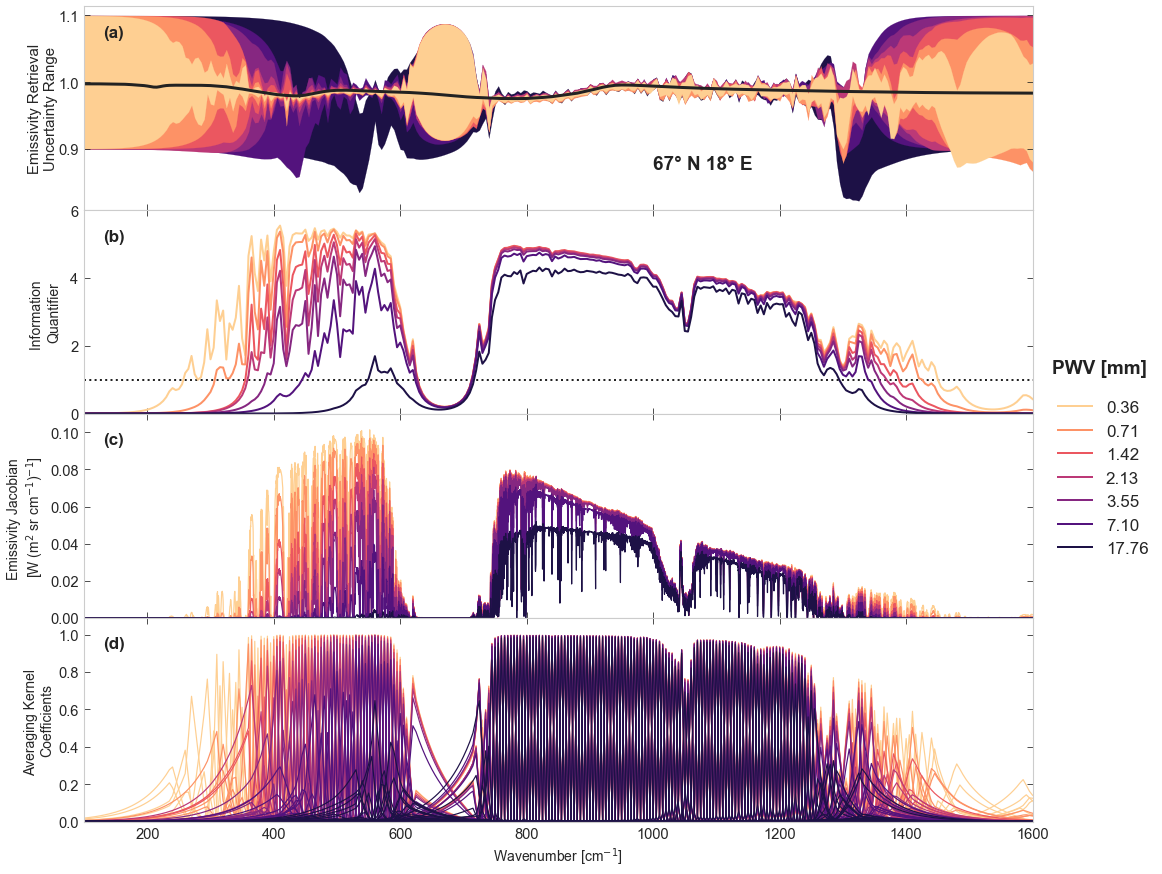

In [21]:
%matplotlib inline
case = '6718'
fontsize=15
fig = plt.figure(figsize=(17,15))
gs = fig.add_gridspec(4, 1)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
runs = [x[0] for x in os.walk('OUTPUTS/Final/')]
wvps = []
err = '1050'
for run in runs:
    if 'f{}'.format(err) in run:
        if run[-1] == '0':
            if case in run:
                if 'wvp' in run:
                    wvps.append(run[22:-14])
wvps = np.sort(np.array([int(wvp) for wvp in wvps]))
wvps = [10,20,40,60,100,200,500]
colormap = 'magma_r'
cmap = truncate_colormap(plt.get_cmap('magma_r'), 0.1, 1)
pwvs2 = []
cols = [cmap((i)/(len(wvps))) for i in np.arange(0,len(wvps))]
for i, wvp in enumerate(wvps[::-1]):
    col=cols[::-1][i]
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,wvp,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,wvp,err))
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
    emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])
    ax0.fill_between(ds_l2m['egrid'][:], ds_l2m['EMISS'][:]+emerr,ds_l2m['EMISS'][:]-emerr,color=col)

    
pwvs2 = []
for i, wvp in enumerate(wvps):
    col=cols[i]
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,wvp,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,wvp,err))
    z, Tskin, T, p, gases2, cloud_data = get_fsi_reference_data(ds_ref, 37, 37)
    em_ap_vcm = ds_l2m['EMISS_APCM'][:]
    ak_em = ds_l2m['ak'][:][:,em_idc[0]][em_idc[0],:]
    emvar = ds_l2m['sx'][:][em_idc,em_idc][0]
    lat = ds_ref['lat_ssp'][:]
    pwv2 = pwv(z,p*100,gases2[0]*1e-6,lat)
    pwvs2.append(pwv2)
    iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
    ax1.plot(ds_l2m['egrid'][:],iq,color=col,linewidth=2,label='{:.2f}'.format(pwv2))
    folder='Final/EM_{}_{}wvp_emAP_f{}'.format(case,wvp,err)
    f = 'OUTPUTS/{}/d_emi_num_full.dat'.format(folder)
    dset = pd.read_csv(f, header=None, sep=' ', skipinitialspace=True, skiprows=2, names=['wn', 'rad'])
    ax2.plot(dset['wn'],dset['rad'], color=col,linestyle='-')
    for idc, j  in enumerate(np.arange(0,301)):
        ax3.plot(ds_l2m['egrid'], ak_em[j,:],label='{:.0f}'.format(ds_l2m['egrid'][:][j]), color=col,alpha=1)



ax0.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=False, labelsize=fontsize)
ax0.set_ylabel('Emissivity Retrieval\nUncertainty Range', labelpad=0, fontsize=fontsize)
ax0.plot(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], linewidth=3, color='k',label='True emissivity')
ax0.set_xlim(100,1600)
ax1.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0., fontsize=fontsize+2,frameon=False)
ax1.text(1.02, 0.2, 'PWV [mm]', fontweight='bold', color='k', transform=ax1.transAxes, fontsize=fontsize+4)


ax1.hlines(1,100,1600,color='k',linestyle=':',linewidth=2)
ax1.set_xlim(100, 1600)
ax1.set_ylim(-0.01,6)
ax1.set_ylabel('Information \nQuantifier', labelpad=10, fontsize=fontsize-1)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_xlim(100,1600)
ax2.set_ylim(0,0.11)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('Emissivity Jacobian \n[W (m$^2$ sr cm$^{-1}$)$^{-1}$]',fontsize=fontsize-1)
ax3.set_xlim(100,1600)
ax3.set_ylim(0,1.09)
ax3.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize-1)
ax3.set_ylabel('Averaging Kernel \nCoefficients',fontsize=fontsize-1)

ax0.text(0.6, 0.2, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color='k', transform=ax0.transAxes, fontsize=fontsize+4)
for i, ax in enumerate(fig.axes):
    ax.text(0.02, 0.85, labels[i], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+2)


fig.subplots_adjust(hspace=0)
fig.savefig('plots/fig04.pdf',bbox_inches='tight')
plt.show()

## Basic retrievals

In [22]:
def IQ_emiss_rms(ds_l2m,ds_ref,min_iq=1):
    # according to INFORMATION QUANTIFIER
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
    emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
    em_ap_vcm = ds_l2m['EMISS_APCM'][:]
    iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
    idc2 = np.where(iq>min_iq)
    
    rms2 = np.sqrt(np.sum(np.square(ds_l2m['EMISS'][:][idc2]-ds_ref['emissivity1'][:][10:-10][idc2]))/len(ds_l2m['EMISS'][:][idc2]))
    return rms2

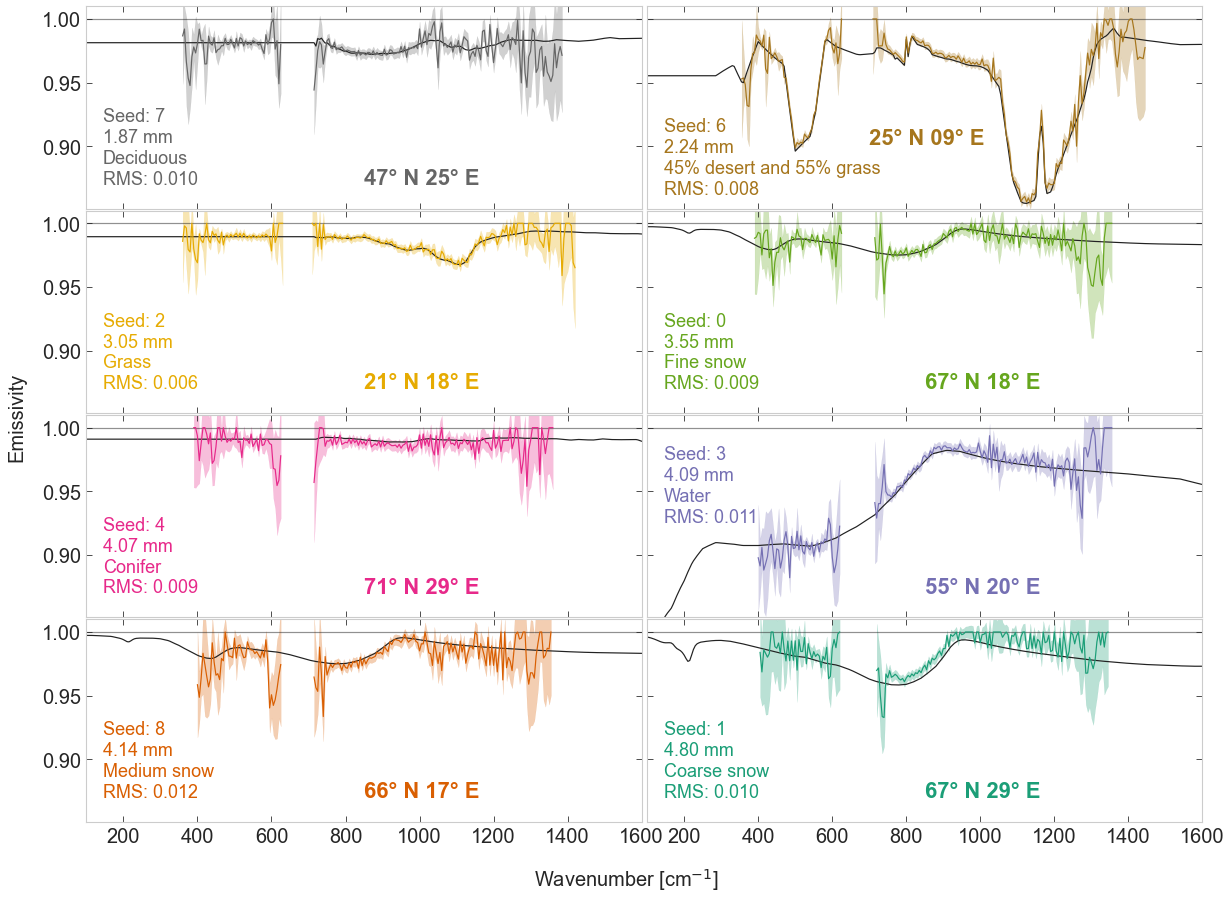

In [23]:
err = '1050'
cases = ['4725_7iseed','2509_6iseed','2118_2iseed','6718','7129_4iseed','5520_3iseed','6617_8iseed','6729_1iseed']
types = ['Deciduous','45% desert and 55% grass','Grass','Fine snow','Conifer','Water','Medium snow','Coarse snow','Ice']
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,15))
fontsize=20
color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666'][::-1]
for i, case in enumerate(cases):
    ax = fig.add_subplot(421+i)
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
    ig_em = ds_l2m['rv_ig'][:][em_idc[0]]
    emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])
    z, Tskin, T, p, gases, cloud_data = get_fsi_reference_data(ds_ref, 37, 37)
    lat_ssp = ds_ref['lat_ssp'][:]
    rms = IQ_emiss_rms(ds_l2m,ds_ref,1)
    emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
    em_ap_vcm = ds_l2m['EMISS_APCM'][:]
    iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
    idc = np.where(iq>1)
    win1 = np.where((ds_l2m['egrid'][:]<=650)&(iq>1))
    win2 = np.where((ds_l2m['egrid'][:]>=650)&(iq>1))
    windows = [win1,win2]
    col = list(colors.TABLEAU_COLORS.values())[i]
    col = color_list[i]
    ax.plot(ds_l2m['egrid'], ds_l2m['EMISS_AP'], color='k', alpha=0.5,label='A-priori emissivity')
    ax.plot(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], color='k',linestyle='-',label='True emissivity')
    pwv2 = pwv(z,p*100,gases[0]*1e-6,lat_ssp)
    for j, win in enumerate(windows):
        if j==0:
            ax.plot(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win],color=col,label='Retrieved emissivity \nwith 1$\sigma$ errorbars')
            ax.fill_between(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win]+emerr[win],ds_l2m['EMISS'][:][win]-emerr[win],color=col,alpha=0.3)
        else:
            ax.plot(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win],color=col)
            ax.fill_between(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win]+emerr[win],ds_l2m['EMISS'][:][win]-emerr[win],color=col,alpha=0.3)
    if case=='6718':
        ax.text(0.5, 0.2, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color=col, transform=ax.transAxes, fontsize=fontsize+2,va='top')
        ax.text(0.03, 0.5, 'Seed: {}\n{:.2f} mm\n{}\nRMS: {:.3f}'.format(0,pwv2,types[i],rms), color=col, transform=ax.transAxes, fontsize=fontsize-2,va='top')
    elif case=='5520_3iseed':
        ax.text(0.5, 0.2, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color=col, transform=ax.transAxes, fontsize=fontsize+2,va='top')
        ax.text(0.03, 0.85, 'Seed: {}\n{:.2f} mm\n{}\nRMS: {:.3f}'.format(case[5:6],pwv2,types[i],rms), color=col, transform=ax.transAxes, fontsize=fontsize-2,va='top')
    elif '2509' in case:
        ax.text(0.4, 0.4, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color=col, transform=ax.transAxes, fontsize=fontsize+2,va='top')
        ax.text(0.03, 0.45, 'Seed: {}\n{:.2f} mm\n{}\nRMS: {:.3f}'.format(case[5:6],pwv2,types[i],rms), color=col, transform=ax.transAxes, fontsize=fontsize-2,va='top')
    else:    
        ax.text(0.5, 0.2, '{}° N {}° E'.format(case[0:2],case[2:4]), fontweight='bold', color=col, transform=ax.transAxes, fontsize=fontsize+2,va='top')
        ax.text(0.03, 0.5, 'Seed: {}\n{:.2f} mm\n{}\nRMS: {:.3f}'.format(case[5:6],pwv2,types[i],rms), color=col, transform=ax.transAxes, fontsize=fontsize-2,va='top')


    ax.set_xlim(right=1600, left=100)
    if (i != 6) and (i != 7):
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
    else:
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=True, labelsize=fontsize)
    if (i%2)==1:
        ax.tick_params(axis='y', which='both', labelleft=False)
    else:
        ax.tick_params(axis='y', which='both',  labelsize=fontsize)
    ax.grid(False)
    ax.set_ylim(0.851,1.01)
ax.set_xlim(right=1600, left=100)
fig.supxlabel('Wavenumber [cm$^{-1}$]', y=0.06,fontsize=fontsize)
fig.supylabel('Emissivity', x=0.07,fontsize=fontsize)
fig.subplots_adjust(hspace=0.01,wspace=0.01)
fig.patch.set_alpha(1)
fig.savefig('plots/fig05.pdf',bbox_inches='tight')
plt.show()

# Water Vapour

In [24]:
def fixed_range_rms(ds_l2m,ds_ref, mn=100, mx=600):
    rang = np.where((ds_l2m['egrid'][:]<=mx) & (ds_l2m['egrid'][:]>=mn))[0]
    
    rms = np.sqrt(np.sum(np.square(ds_l2m['EMISS'][:][rang]-ds_ref['emissivity1'][:][10:-10][rang]))/len(ds_l2m['EMISS'][:][rang]))
    return rms

['0.4', '0.7', '1.4', '1.8', '2.1', '2.5', '2.8', '3.2', '3.6', '3.9', '4.3', '4.6', '5.0', '7.1', '10.7', '17.8'] ['260', '310', '360', '360', '360', '360', '380', '385', '390', '395', '400', '400', '400', '445', '480', '550']


/tmp/ipykernel_49918/3480732711.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs1.tight_layout(fig, rect=[0, 0.7, 1, 1])
/tmp/ipykernel_49918/3480732711.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0, 0, 1, 0.7],h_pad=0)


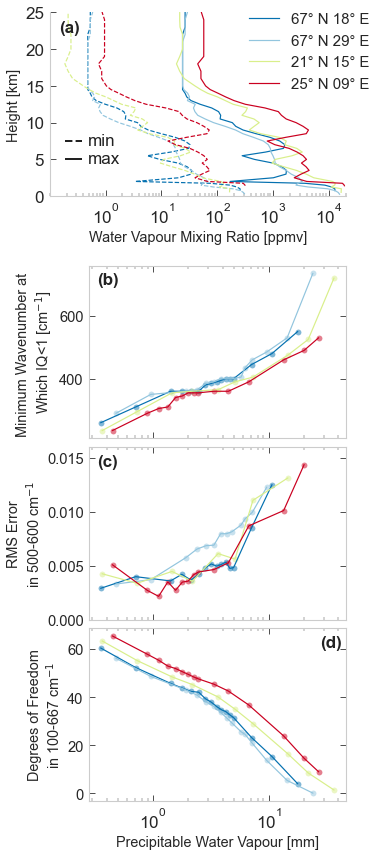

In [25]:
wvps = ['40wvp_','50wvp_','60wvp_','70wvp_','80wvp_','90wvp_','','110wvp_','120wvp_','130wvp_','140wvp_','200wvp_']
txts = ['40%','50%','60%','70%','80%','90%','100%','110%','120%','130%','140%','200%']
%matplotlib inline
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(5,12))
gs1 = gridspec.GridSpec(1, 1)
ax0 = fig.add_subplot(gs1[0])

gs2 = gridspec.GridSpec(3, 1)
ax1 = fig.add_subplot(gs2[0])
ax2 = fig.add_subplot(gs2[1],sharex=ax1)
ax3 = fig.add_subplot(gs2[2],sharex=ax1)


fontsize=20
color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
color_list =['#ca0020','#d9ef8b','#92c5de','#0571b0'][::-1]
cases = ['6729','5520','2509','2118']
cases = ['6718','6729','2115','2509']

for j, case in enumerate(cases):
    runs = [x[0] for x in os.walk('OUTPUTS/Final/')]
    wvps = []
    err = '1050'
    for run in runs:
        if 'f{}'.format(err) in run:
            if run[-1] == '0':
                if case in run:
                    if 'wvp' in run:
                        wvps.append(run[22:-14])
    wvps = np.sort(np.array([int(wvp) for wvp in wvps]))

    minsens = []
    rmss= []
    dofs = []
    pwvs2 = []
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,wvps[0],err))
    z, Tskin, T, p, gases2, cloud_data = get_fsi_reference_data(ds_ref, 37, 37)
    wvprofs = np.zeros((len(wvps),len(z)))
    
    col = color_list[j]
    
    for i, wvp in enumerate(wvps):
        ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,wvp,err))
        ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_{}wvp_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,wvp,err))
        em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
        ak_em = ds_l2m['ak'][:][:,em_idc[0]][em_idc[0],:]
        em_ap_vcm = ds_l2m['EMISS_APCM'][:]
        emvar = ds_l2m['sx'][:][em_idc,em_idc]
        em_ap_vcm = ds_l2m['EMISS_APCM'][:]
        iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
        idc = np.where(iq[0]>1)[0]
        minsen = ds_l2m['egrid'][:][idc[0]]

        z, Tskin, T, p, gases2, cloud_data = get_fsi_reference_data(ds_ref, 37, 37)
        lat = ds_ref['lat_ssp'][:]
        pwv2 = pwv(z,p*100,gases2[0]*1e-6,lat)
        pwvs2.append(pwv2)
        minsens.append(minsen)
        rmss.append(fixed_range_rms(ds_l2m,ds_ref,500,600))

        rang = np.where((ds_l2m['egrid'][:]<=667) & (ds_l2m['egrid'][:]>=100))[0]
        dof = np.sum(np.diag(ak_em)[rang])
        dofs.append(dof)
        wvprofs[i,:]=gases2[0]

        
    ax1.plot(pwvs2,minsens, color=col,label='{}° N {}° E'.format(case[0:2],case[2:4]))
    ax1.scatter(pwvs2,minsens, color=col,alpha=0.5)
    ax1.set_ylabel('Minimum Wavenumber at \nWhich IQ<1 [cm$^{-1}$]')
    ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize-3)
    ax1.set_xscale('log')
    if case in ['6718']:
        print(['{:.1f}'.format(pwv22) for pwv22 in pwvs2],['{:.0f}'.format(minsenn) for minsenn in minsens])

    rms_idc = np.where(np.array(minsens)<=501)[0]
    ax2.plot(np.array(pwvs2)[rms_idc],np.array(rmss)[rms_idc], color=col)
    ax2.scatter(np.array(pwvs2)[rms_idc],np.array(rmss)[rms_idc], color=col,alpha=0.5)
    ax2.set_ylabel('RMS Error\nin 500-600 cm$^{-1}$')
    ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize-3)
    ax2.set_xscale('log')
    ax2.set_ylim(0,0.016)

    
    ax3.plot(pwvs2,dofs, color=col)
    ax3.scatter(pwvs2,dofs, color=col,alpha=0.5)
    ax3.set_ylabel('Degrees of Freedom\nin 100-667 cm$^{-1}$')
    ax3.set_xlabel('Precipitable Water Vapour [mm]')
    ax3.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=True, labelsize=fontsize-3)
    ax3.set_xscale('log')

    ax0.plot(np.min(wvprofs,axis=0),z*0.001,linestyle='--',color=col)
    ax0.plot(np.max(wvprofs,axis=0),z*0.001,linestyle='-',color=col)
ax0.set_xlabel('Water Vapour Mixing Ratio [ppmv]')
ax0.set_ylabel('Height [km]')
ax0.set_ylim(0,25)
ax0.grid(False)
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=True, labelsize=fontsize-3)
ax0.tick_params(axis='y', which='both',left=True,right=False,labelleft=True, labelsize=fontsize-3)
ax0.set_xscale('log')
ax0.set_xticks([1,10,100,1e3,1e4])
locmin = mpl.ticker.LogLocator(base=10.0,subs='all',numticks=20)
ax0.xaxis.set_minor_locator(locmin)
ax0.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax0.hlines(0.3,0.05,0.11,transform=ax0.transAxes,color='k',linestyle='--',linewidth=2)
ax0.text(0.13,0.28,'min',color='k',transform=ax0.transAxes,fontsize=fontsize-3)
ax0.hlines(0.2,0.05,0.11,transform=ax0.transAxes,color='k',linestyle='-',linewidth=2)
ax0.text(0.13,0.18,'max',color='k',transform=ax0.transAxes,fontsize=fontsize-3)
ax0.set_xlim(0.1,20000)


ax0.text(0.03, 0.89, labels[0], fontweight='bold', color='k', transform=ax0.transAxes, fontsize=fontsize-3)
ax1.text(0.03, 0.89, labels[1], fontweight='bold', color='k', transform=ax1.transAxes, fontsize=fontsize-3)
ax2.text(0.03, 0.89, labels[2], fontweight='bold', color='k', transform=ax2.transAxes, fontsize=fontsize-3)
ax3.text(0.9, 0.89, labels[3], fontweight='bold', color='k', transform=ax3.transAxes, fontsize=fontsize-3)


gs1.tight_layout(fig, rect=[0, 0.7, 1, 1])
gs2.tight_layout(fig, rect=[0, 0, 1, 0.7],h_pad=0)

ax1.legend(bbox_to_anchor=(0.6, 2.5), loc='upper left', borderaxespad=0., fontsize=fontsize-5,ncol=1,frameon=False)

fig.patch.set_alpha(1)
fig.savefig('plots/fig06.pdf',bbox_inches='tight')
plt.show()

# Surface Temperature

## Retrievals

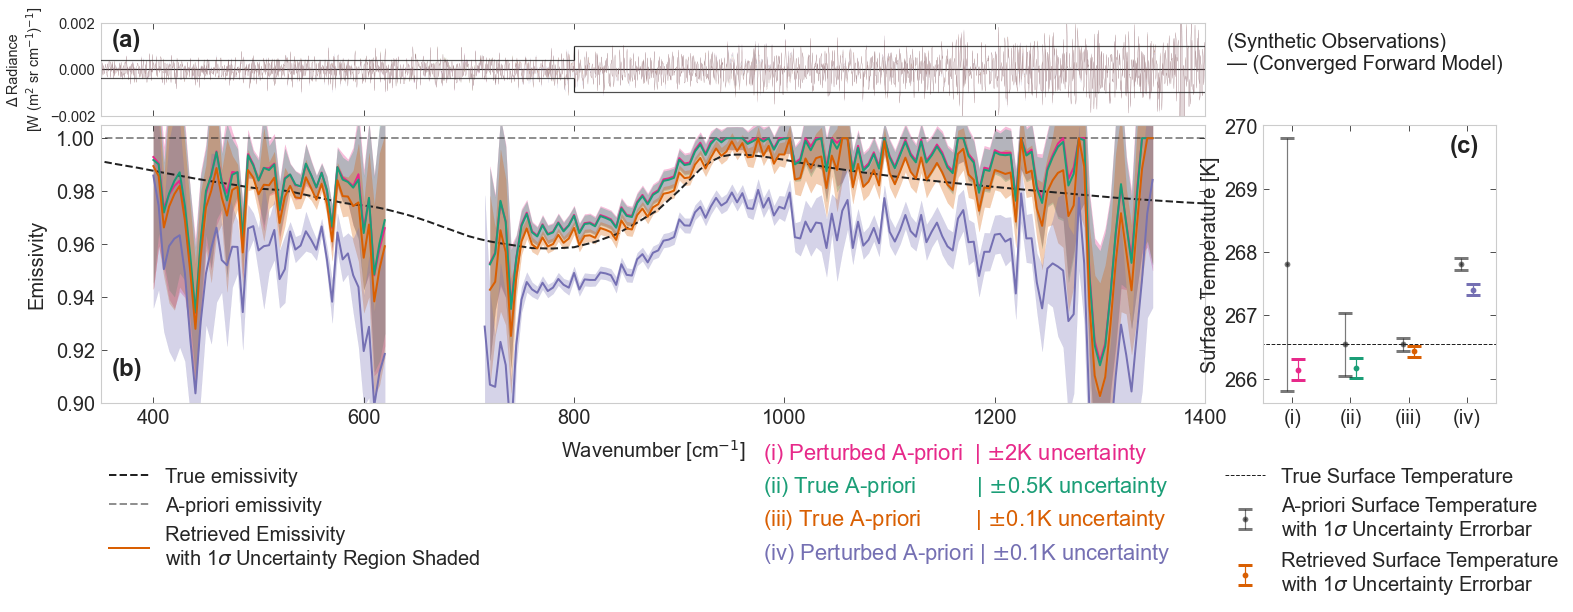

In [26]:
case = '6729'
%matplotlib inline 
color_list = ['#e7298a','#1b9e77','#d95f02','#7570b3']
errs = ['1050','1050_trueTs','1050_trueTs1','1050_trueTs1_pofftrueTs1']
txts = ['(i) Perturbed A-priori  | $\pm$2K uncertainty',
        '(ii) True A-priori          | $\pm$0.5K uncertainty',
        '(iii) True A-priori         | $\pm$0.1K uncertainty',
        '(iv) Perturbed A-priori | $\pm$0.1K uncertainty']
err_txts = ['(i)','(ii)','(iii)','(iv)']
labeltxts = ['_','_','Retrieved Emissivity\nwith 1$\sigma$ Uncertainty Region Shaded','_']
Tlabeltxts = ['_','_','Retrieved Surface Temperature\nwith 1$\sigma$ Uncertainty Errorbar','_']
Taplabeltxts = ['A-priori Surface Temperature\nwith 1$\sigma$ Uncertainty Errorbar','_','_','_']

fig = plt.figure(figsize=(25,7))
gs = fig.add_gridspec(2, 5,height_ratios=[1,3])
ax1 = fig.add_subplot(gs[1, 0:4])
ax2 = fig.add_subplot(gs[1, 4])
ax3 = fig.add_subplot(gs[0, 0:4],sharex=ax1)


ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,errs[0]))
ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,errs[0]))
ax1.plot(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], linewidth=2, color='k',label='True emissivity',linestyle='--')
ax1.plot(ds_l2m['egrid'], ds_l2m['EMISS_AP'], label='A-priori emissivity', color='k',linewidth=2, alpha=0.5,linestyle='--')
for i, err in enumerate(errs):
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2) 
    emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])
    emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
    em_ap_vcm = ds_l2m['EMISS_APCM'][:]
    iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
    idc = np.where(iq>1)
    win1 = np.where((ds_l2m['egrid'][:]<=650)&(iq>1))
    win2 = np.where((ds_l2m['egrid'][:]>=650)&(iq>1))
    windows = [win1,win2]
    col = list(colors.TABLEAU_COLORS.values())[i]
    col = color_list[i]
    for j, win in enumerate(windows):
        if j==0:
            ax1.plot(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win],color=col,label=labeltxts[i],linewidth=2)
            ax1.fill_between(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win]+emerr[win],ds_l2m['EMISS'][:][win]-emerr[win],color=col,alpha=0.3)
        else:
            ax1.plot(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win],color=col,linewidth=2)
            ax1.fill_between(ds_l2m['egrid'][:][win], ds_l2m['EMISS'][:][win]+emerr[win],ds_l2m['EMISS'][:][win]-emerr[win],color=col,alpha=0.3)
    ax1.text(0.6, -0.2-i*0.12, txts[i], color=col, transform=ax1.transAxes, fontsize=fontsize+2)
    ax1.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=True, labelsize=fontsize)
    ax1.tick_params(axis='y', which='both', labelsize=fontsize)
    ax1.set_xlabel('Wavenumber [cm$^{-1}$]', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('Emissivity', labelpad=10, fontsize=fontsize)
    ax2.errorbar(i+0.1,ds_l2m['TSKIN'][:],yerr=np.sqrt(ds_l2m['sx'][:][0,0]), linestyle='',capsize=7,markeredgewidth=3, marker='.',color=col,label=Tlabeltxts[i])
    ax2.errorbar(i-0.1,ds_l2m['TSKIN_AP'][:],yerr=np.sqrt(ds_l2m['TSKIN_APCM'][:]),linestyle='',capsize=7,markeredgewidth=3,marker='.',label=Taplabeltxts[i], color='k',alpha=0.6)
 
    wn = ds_l2m['wn']
    diff = ds_l2m['spec_instr'][:]-ds_l2m['spec_final'][:]
    ax3.plot(wn,diff,linewidth=0.1,color=color_list[i],alpha=0.7)
    
ax2.grid(False)

ax1.tick_params(axis='y', which='both', left=True,right=True,labelsize=fontsize)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=True, labelsize=fontsize)
ax3.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=True, labelsize=fontsize)
ax2.tick_params(axis='y', which='both', left=True,right=True,labelsize=fontsize)
ax1.grid(False)
ax2.set_xlim(-0.5,-0.5+len(errs))
ax2.hlines(ds_ref['Tskin'][:][30,30],-1,4,color='k',linestyle='--', linewidth=1,label='True Surface Temperature')
ax2.set_ylabel('Surface Temperature [K]',fontsize=fontsize)

ax2.set_xticks(ticks=np.arange(0,len(errs)))
ax2.set_xticklabels(labels=err_txts,fontsize=fontsize)
ax1.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0., fontsize=fontsize,title_fontsize=fontsize,frameon=False)

ax2.legend(bbox_to_anchor=(-0.2, -0.2), loc='upper left', borderaxespad=0., fontsize=fontsize,title_fontsize=fontsize,frameon=False)

ax1.text(0.01, 0.1, labels[1], fontweight='bold', color='k', transform=ax1.transAxes, fontsize=fontsize+4)
ax2.text(0.8, 0.9, labels[2], fontweight='bold', color='k', transform=ax2.transAxes, fontsize=fontsize+4)
ax3.text(0.01, 0.75, labels[0], fontweight='bold', color='k', transform=ax3.transAxes, fontsize=fontsize+4)
ax3.text(1.02, 0.5, '(Synthetic Observations)\n— (Converged Forward Model)', color='k', transform=ax3.transAxes, fontsize=fontsize)

ax1.set_xlim(right=1400, left=350)
ax1.set_ylim(top=1.005,bottom=0.9)


yline = np.array([1,0.4,1])
xline1 = np.array([100,200,800])
xline2 = np.array([200,800,1600])
ax3.hlines(yline/1000,xline1,xline2,color='k', zorder=10,alpha=0.8)
ax3.hlines(-yline/1000,xline1,xline2,color='k', zorder=10,alpha=0.8)
ax3.hlines(0,100,1600,color='k')
ax3.vlines([200,800],-1/1000,-0.4/1000,color='k',zorder=100)
ax3.vlines([200,800],0.4/1000,1/1000,color='k',zorder=100)
ax3.set_xlim(right=1400, left=350)
ax3.set_ylim(-0.002,0.002)
ax3.set_ylabel('Δ Radiance\n[W (m$^2$ sr cm$^{-1}$)$^{-1}$]')


fig.subplots_adjust(wspace=0.25,hspace=0.05)

fig.patch.set_alpha(1)
fig.savefig('plots/fig07.pdf',bbox_inches='tight')
plt.show()

## Differen a-prioris

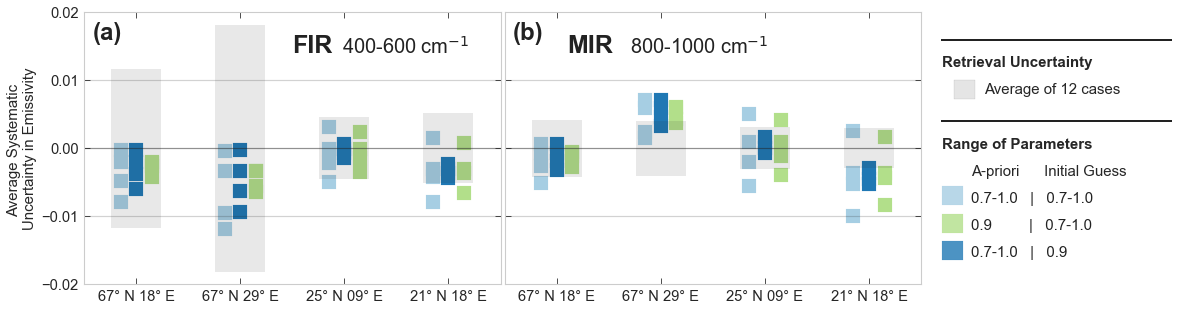

In [27]:
%matplotlib inline
import matplotlib.font_manager
typss = ['Coarse Snow','Fine Snow','Desert & Grass','Grass']
err_lists = [['1050','1050_flat2','1050_flat4','1050_flat3'],
             ['1050_flatIG4_flatAP','1050_flatIG4_flatAP2', '1050_flatIG4_flatAP3','1050_flat4'],
             ['1050_flatIG_flatAP4', '1050_flatIG3_flatAP4', '1050_flatIG2_flatAP4', '1050_flat4']]
txts = ['A-priori','Initial Guess','Both'][::-1]
cases = ['6718','6729','2509','2118']
color_list = ['#a6cee3','#1f78b4','#b2df8a']
marker_list = ['s','s','s']

bin_stp = 20
fontsize=20
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for j, case in enumerate(cases):
    errsMIR = []
    errsFIR = []
    for i, errs in enumerate(err_lists):
        col = color_list[i]
        for ie, err in enumerate(errs):
            ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
            ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
            f = interpolate.interp1d(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], fill_value='extrapolate', kind='cubic')
            em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
            emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])

            emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
            em_ap_vcm = ds_l2m['EMISS_APCM'][:]
            iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
            idc = np.where((ds_l2m['egrid'][:]>=400)&(ds_l2m['egrid'][:]<=600))
            avg = np.average(ds_l2m['EMISS'][idc][:]-f(np.array(ds_l2m['egrid'][idc][:])))
            ax1.scatter(j-0.15+0.15*i,avg,color=col,s=200,marker=marker_list[i])
            errsFIR.append(np.average(emerr[idc][:]))

            idc = np.where((ds_l2m['egrid'][:]>=800)&(ds_l2m['egrid'][:]<=1000))
            avg = np.average(ds_l2m['EMISS'][idc][:]-f(np.array(ds_l2m['egrid'][idc][:])))
            ax2.scatter(j-0.15+0.15*i,avg,color=col,s=200,marker=marker_list[i])
            errsMIR.append(np.average(emerr[idc][:]))
    errMIR = np.average(errsMIR)
    errFIR = np.average(errsFIR)
    ax1.vlines(j,-errFIR,errFIR,color='k',alpha=0.1,linewidth=50)
    ax2.vlines(j,-errMIR,errMIR,color='k',alpha=0.1,linewidth=50)

ax1.set_xlim(-0.5,3.5)
ax2.set_xlim(-0.5,3.5)
ax1.set_ylim(-0.02,0.02)
ax2.set_ylim(-0.02,0.02)
ax1.hlines(0,-1,5, linestyle='-',color='k',alpha=0.5)
ax1.hlines([-0.01,0.01],-1,5, linestyle='-',color='k',alpha=0.2)
ax2.hlines(0,-1,5, linestyle='-',color='k',alpha=0.5)
ax2.hlines([-0.01,0.01],-1,5, linestyle='-',color='k',alpha=0.2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(['{}° N {}° E'.format(case[0:2],case[2:4]) for case in cases])
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['{}° N {}° E'.format(case[0:2],case[2:4]) for case in cases])
ax2.tick_params(axis='y', which='both',bottom=True,top=True,labelleft=False, labelsize=fontsize)
ax1.set_yticks([-0.02,-0.01,0,0.01,0.02])

ax1.text(0.5,0.85,'FIR',color='k',fontweight='bold',transform=ax1.transAxes,fontsize=25)
ax1.text(0.62,0.85,'400-600 cm$^{-1}$',color='k',transform=ax1.transAxes,fontsize=20)
ax1.set_ylabel('Average Systematic \nUncertainty in Emissivity',fontsize=fontsize-5)
ax2.text(0.15,0.85,'MIR',color='k',fontweight='bold',transform=ax2.transAxes,fontsize=25)
ax2.text(0.3,0.85,'800-1000 cm$^{-1}$',color='k',transform=ax2.transAxes,fontsize=20)

ax2.plot([1.05,1.6],[0.6,0.6],transform=ax2.transAxes,color='k',clip_on=False,linewidth=2)   
ax2.text(1.05,0.5,'Range of Parameters',transform=ax2.transAxes,fontsize=fontsize-5,fontweight='bold')
ax2.text(1.12,0.4,'A-priori      Initial Guess',transform=ax2.transAxes,fontsize=fontsize-5)
color_list = ['#a6cee3','#b2df8a','#1f78b4']
txts2 = ['0.7-1.0   |   0.7-1.0', '0.9         |   0.7-1.0','0.7-1.0   |   0.9']
for i, txt in enumerate(txts2[::-1]):
    leg_rect1 = mpl.patches.Rectangle((1.05,0.09+i*0.1), 0.05, 0.07, transform=ax2.transAxes,color=color_list[::-1][i],alpha=0.8,clip_on=False)
    ax2.add_patch(leg_rect1)
    ax2.text(1.12,0.1+i*0.1,txt,color='k',transform=ax2.transAxes,fontsize=fontsize-5)
    

ax2.text(1.15,0.7,'Average of 12 cases',transform=ax2.transAxes,fontsize=fontsize-5)
leg_rect2 = mpl.patches.Rectangle((1.08,0.68), 0.05, 0.07, transform=ax2.transAxes,fill=True,alpha=0.5,edgecolor='k',clip_on=False)
ax2.add_patch(leg_rect2)
ax2.plot([1.05,1.6],[0.9,0.9],transform=ax2.transAxes,color='k',clip_on=False,linewidth=2)   
ax2.text(1.05,0.8,'Retrieval Uncertainty',transform=ax2.transAxes,fontsize=fontsize-5,fontweight='bold')
ax1.text(0.02, 0.9, labels[0], fontweight='bold', color='k', transform=ax1.transAxes, fontsize=fontsize+4)
ax2.text(0.02, 0.9, labels[1], fontweight='bold', color='k', transform=ax2.transAxes, fontsize=fontsize+4)


fig.patch.set_alpha(1)
fig.subplots_adjust(wspace=0.01)
fig.savefig('plots/fig08.pdf',bbox_inches='tight')

plt.show()

In [28]:
err_lists = [['1050','1050_flat3'],['1050_flatIG4_flatAP', '1050_flatIG4_flatAP3'],['1050_flatIG_flatAP4', '1050_flatIG3_flatAP4']]
cases = ['6718','6729','2509','2118']
errs = ['1050_flatIG_flatAP4', '1050_flat4', '1050_flatIG2_flatAP4', '1050_flatIG3_flatAP4'][::-1]
IGs = [0.7,0.8,0.9,1]
conv_data = np.zeros((16,6))
idc = 0
for j, case in enumerate(cases):
    for i, err in enumerate(errs):
        ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
        conv_data[idc,:]=np.array([case,IGs[i],ds_l2m['cind'][:],ds_l2m['itcount'][:],ds_l2m['chi2'][:][-1],ds_l2m['chi2'][0]])
        idc += 1

In [29]:
d = {'scene': ['{:.0f}'.format(conv) for conv in conv_data[:,0]],
    'IG':conv_data[:,1],
    'cind':['{:.0f}'.format(conv) for conv in conv_data[:,2]],
     'itcount':['{:.0f}'.format(conv) for conv in conv_data[:,3]],
     'final chi2':np.around(conv_data[:,4],2),
     'initial chi2':np.around(conv_data[:,5],2)
    }
df_convdata = pd.DataFrame(data=d)
# df_convdata.to_hdf('convdata.h5', key='df_convdata', mode='w')
# df_convdata.to_csv('paperplots/convdata.csv',index=None)
display(df_convdata)

,scene,IG,cind,itcount,final chi2,initial chi2
0,6718,0.7,121,5,1.22,453.26
1,6718,0.8,121,5,1.21,251.17
2,6718,0.9,121,5,1.21,115.51
3,6718,1.0,121,5,1.21,46.30
4,6729,0.7,121,5,1.26,585.82
5,6729,0.8,121,4,1.26,360.81
6,6729,0.9,121,5,1.27,206.24
7,6729,1.0,121,5,1.27,122.12
8,2509,0.7,121,6,1.29,1082.61
9,2509,0.8,121,6,1.28,617.30


# Appendix - Correlation

In [30]:
df = pd.read_hdf('runs.h5','df')

In [31]:
def BT(wn, T):
    return np.divide(2e8*h*c**2*np.power(wn,3,dtype="float"),np.exp(100*h*c*wn/(k_b*T))-1)
def dBT(wn, T):
    return np.divide(2e10*(h**2)*(c**3)*np.power(wn,4,dtype="float"),k_b*T)*np.divide(np.exp(100*h*c*wn/(k_b*T)),(np.exp(100*h*c*wn/(k_b*T))-1)**2)

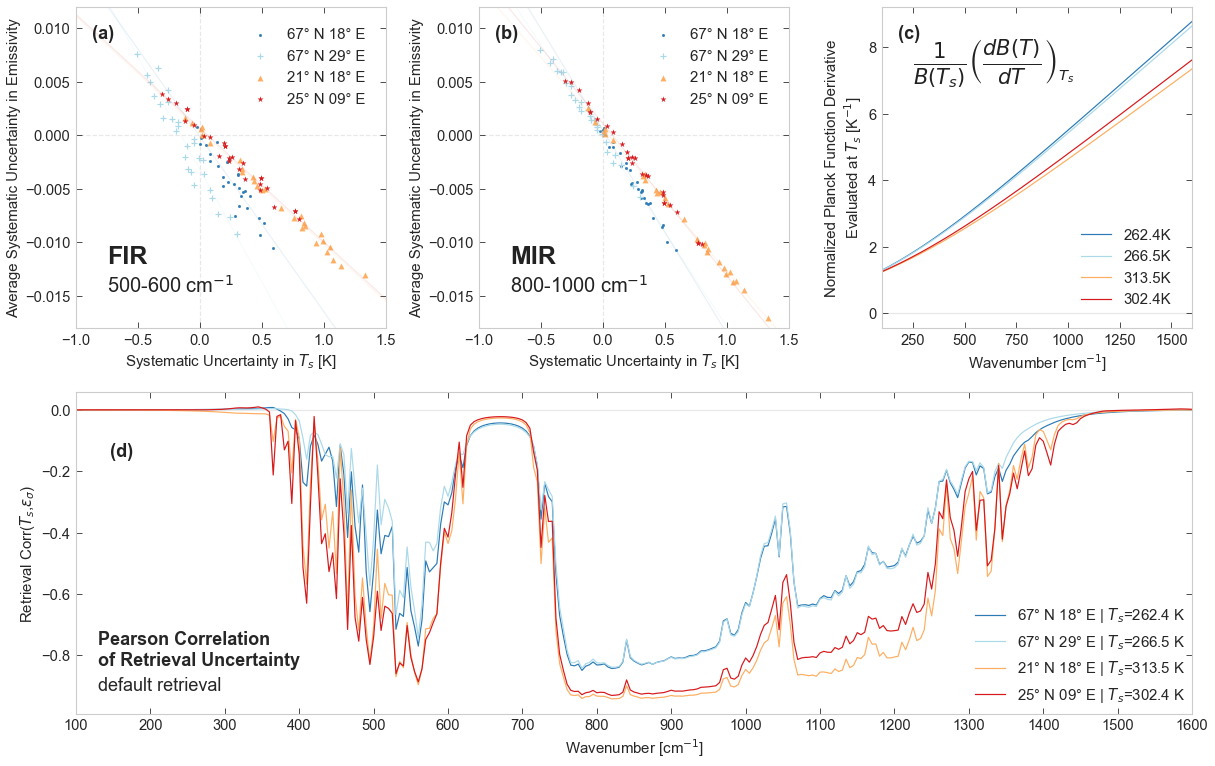

In [32]:
color_list = ['#d7191c','#fdae61','#abd9e9','#2c7bb6'][::-1]
marker_list = ['.','+','^','*','x']
cases = ['6718','6729','2118','2509']
# cases = ['6718']
err = '1050'
fontsize=15
%matplotlib inline
fig = plt.figure(figsize=(20,13))
gs = fig.add_gridspec(2, 3)
corr_data_FIR = np.zeros((6,4))
corr_data_MIR = np.zeros((6,4))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1],sharey=ax1,sharex=ax1)
for j, case in enumerate(cases):
    run_names = df[(df['Scene location']=='{}°N {}°E'.format(case[0:2],case[2:4]))
                  & (df['Other']=='')
                  & (df['Water Vapour Precentage [%]']=='')
                  & (df['Ts AP']!='config file')
                  & (df['Emiss retrieval bins']=='def')
                  & (df['Emiss AP error']=='Δε=0.10 CL=50')
                    & (df['Ts AP error [K]']=='2')
                   & (df['FSI seed'].isin(['0','1','2','3','4','5','6']))
#                   & (df['FSI seed'].isin(['0','1','2','3','4','5']))
                  & (df['CONF version']).isin(['','_flat2','_flat3','_flat4'])]['Full name']

    Terr = []
    emavgerr_FIR = []
    emavgerr_MIR = []

    for i, run in enumerate(run_names):
        ds_l2m = nc.Dataset("OUTPUTS/Final/EM_{}/fe2es_l2m_out_d0001.nc".format(run))
        ds_ref = nc.Dataset("OUTPUTS/Final/EM_{}/fe2es_sgm_ref_d0001_acq3.nc".format(run))
        f = interpolate.interp1d(ds_ref['wn_emissivity'][:],ds_ref['emissivity1'][:], fill_value='extrapolate', kind='cubic')
        
        idc = np.where((ds_l2m['egrid'][:]>=500)&(ds_l2m['egrid'][:]<=600))
        avg = np.average(ds_l2m['EMISS'][idc][:]-f(np.array(ds_l2m['egrid'][idc][:])))
        emavgerr_FIR.append(avg)
        
        idc = np.where((ds_l2m['egrid'][:]>=800)&(ds_l2m['egrid'][:]<=1000))
        avg = np.average(ds_l2m['EMISS'][idc][:]-f(np.array(ds_l2m['egrid'][idc][:])))
        emavgerr_MIR.append(avg)
        
        terr = ds_l2m['TSKIN']-ds_ref['Tskin'][:][30,30]
        Terr.append(terr)
    Terr = np.array(Terr)
    emavgerr_FIR = np.array(emavgerr_FIR)
    emavgerr_MIR = np.array(emavgerr_MIR)
    
    z = np.polyfit(Terr,emavgerr_FIR, 1)
    p = np.poly1d(z)
    tt = np.arange(-2,2,0.1)
    ax1.plot(tt,p(tt),color=color_list[j],alpha=0.1)
    corr_data_FIR[0,j]=z[0]
    corr_data_FIR[1,j]=z[1]
    
    tau, p_value = stats.kendalltau(Terr, emavgerr_FIR)
    corr_data_FIR[2,j]=tau
    corr_data_FIR[3,j]=p_value
    
    pearsonr, rp_value = stats.pearsonr(Terr, emavgerr_FIR)
    corr_data_FIR[4,j]=pearsonr
    corr_data_FIR[5,j]=rp_value
    
    z = np.polyfit(Terr,emavgerr_MIR, 1)
    p = np.poly1d(z)
    tt = np.arange(-2,2,0.1)
    ax2.plot(tt,p(tt),color=color_list[j],alpha=0.1)  
    corr_data_MIR[0,j]=z[0]
    corr_data_MIR[1,j]=z[1]
    
    tau, p_value = stats.kendalltau(Terr, emavgerr_MIR)
    corr_data_MIR[2,j]=tau
    corr_data_MIR[3,j]=p_value
    
    pearsonr, rp_value = stats.pearsonr(Terr, emavgerr_MIR)
    corr_data_MIR[4,j]=pearsonr
    corr_data_MIR[5,j]=rp_value
    
    
    ax1.scatter(Terr,emavgerr_FIR,marker=marker_list[j],color=color_list[j],label='{}° N {}° E'.format(case[0:2],case[2:4]))
    ax2.scatter(Terr,emavgerr_MIR,marker=marker_list[j],color=color_list[j],label='{}° N {}° E'.format(case[0:2],case[2:4]))
ax1.text(0.1,0.2,'FIR',color='k',fontweight='bold',transform=ax1.transAxes,fontsize=25)
ax1.text(0.1,0.11,'500-600 cm$^{-1}$',color='k',transform=ax1.transAxes,fontsize=20)
ax1.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize)
ax1.hlines(0,-10,10,color='k',alpha=0.1,linestyle='--')
ax1.vlines(0,-10,10,color='k',alpha=0.1,linestyle='--')
ax1.legend(loc='best', borderaxespad=1, fontsize=15,fancybox=False,frameon=False)
ax1.set_xlabel('Systematic Uncertainty in $T_s$ [K]',fontsize=fontsize)
ax1.set_ylabel('Average Systematic Uncertainty in Emissivity',fontsize=fontsize)

ax2.text(0.1,0.2,'MIR',color='k',fontweight='bold',transform=ax2.transAxes,fontsize=25)
ax2.text(0.1,0.11,'800-1000 cm$^{-1}$',color='k',transform=ax2.transAxes,fontsize=20)
ax2.set_ylim(-0.018,0.012)
ax2.hlines(0,-10,10,color='k',alpha=0.1,linestyle='--')
ax2.vlines(0,-10,10,color='k',alpha=0.1,linestyle='--')
ax2.set_xlim(-1,1.5)
ax2.legend(loc='best', borderaxespad=1, fontsize=15,fancybox=False,frameon=False)
ax2.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize)
ax2.set_xlabel('Systematic Uncertainty in $T_s$ [K]',fontsize=fontsize)
ax2.set_ylabel('Average Systematic Uncertainty in Emissivity',fontsize=fontsize)

ax3 = fig.add_subplot(gs[0,2])
wn = np.arange(100,1605,5)
for i, case in enumerate(cases):
    col = color_list[i]
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
    Ts = ds_ref['Tskin'][0,0]
    ax3.plot(wn, np.divide(dBT(wn,Ts),BT(wn,Ts)),color=col,label='{:.1f}K'.format(Ts))
ax3.grid(False)
ax3.set_ylabel('Normalized Planck Function Derivative\nEvaluated at $T_s$ [K$^{-1}$]',fontsize=fontsize)
ax3.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize)
ax3.text(0.1,0.8,r'$\frac{1}{B(T_{s})}\left(\frac{dB(T)}{dT}\right)_{_{T_s}}$',color='k',fontweight='bold',transform=ax3.transAxes,fontsize=30)
ax3.legend(loc='lower right', borderaxespad=1, fontsize=15,fancybox=False,frameon=False)
ax3.set_xlim(100,1600)
ax3.hlines(0,100,1600,color='k',alpha=0.1)

ax4 = fig.add_subplot(gs[1,:])
for i, case in enumerate(cases):
    ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
    ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
    ts_idc = np.where(ds_l2m['rv_idx'][0]==1)[0]
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)[0]
    emerr = np.sqrt(ds_l2m['sx'][:][em_idc,em_idc])
    corr = np.divide(np.concatenate(ds_l2m['sx'][:][:,ts_idc][em_idc,:]),np.sqrt(ds_l2m['sx'][:][0,0])*emerr)
    col = color_list[i]
    ax4.plot(ds_l2m['egrid'][:],corr,label='{}° N {}° E | $T_s$={:.1f} K'.format(case[0:2],case[2:4],ds_ref['Tskin'][:][0,0]),color=col)
#     ax4.scatter(ds_l2m['egrid'][:],corr,color=col,alpha=0.5)

ax4.grid(False)
ax4.set_xlim(100,1600)
ax4.hlines(0,100,1600,color='k',alpha=0.1)
#     ax.set_xlim(700,1000)
# ax.set_ylim(-0.07,1.05)
ax4.set_xticks(np.arange(100,1700,100))
ax4.legend(bbox_to_anchor=(0.8, 0.01),ncol=1, loc='lower left', borderaxespad=0., fontsize=fontsize,frameon=False)
# ax4.tick_params(axis='x', which='both',bottom=True,top=False,labelbottom=True, labelsize=fontsize)
ax4.set_xlabel('Wavenumber [cm$^{-1}$]', fontsize=fontsize)
ax4.set_ylabel('Retrieval Corr($T_s$,$\epsilon_\sigma$)', fontsize=fontsize)
ax4.text(0.02,0.15,'Pearson Correlation\nof Retrieval Uncertainty',fontweight='bold',transform=ax4.transAxes,fontsize=fontsize+3)
ax4.text(0.02,0.07,'default retrieval',transform=ax4.transAxes,fontsize=fontsize+3)
for j, ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.05, 0.9, labels[j], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+3)
ax4.text(0.03, 0.8, labels[3], fontweight='bold', color='k', transform=ax4.transAxes, fontsize=fontsize+3)

fig.subplots_adjust(wspace=0.3)
fig.patch.set_alpha(1)
fig.savefig('plots/fig09.pdf',bbox_inches='tight')
plt.show()

In [33]:
cases = ['6718','6729','2118','2509']
d = {'coords':['{}° N {}° E'.format(scene[0:2],scene[2:4]) for scene in cases],
    'slope':np.around(corr_data_FIR[0],3),
    'intersect':np.around(corr_data_FIR[1],2),
    'tau':np.around(corr_data_FIR[2],2),
    'p':np.around(corr_data_FIR[3],2)
    }
df_corrFIR = pd.DataFrame(data=d)
# df_corrFIR.to_hdf('corr_data_FIR.h5', key='df_corrFIR', mode='w')
cases = ['6718','6729','2118','2509']
d = {'coords':['{}° N {}° E'.format(scene[0:2],scene[2:4]) for scene in cases],
    'slope':np.around(corr_data_MIR[0],3),
    'intersect':np.around(corr_data_MIR[1],2),
    'tau':np.around(corr_data_MIR[2],2),
    'p':np.around(corr_data_MIR[3],2)
    }
df_corrMIR = pd.DataFrame(data=d)
# df_corrMIR.to_hdf('corr_data_MIR.h5', key='df_corrMIR', mode='w')
# df_corrFIR.to_csv('paperplots/corr_data_FIR.csv',index=None)
# df_corrMIR.to_csv('paperplots/corr_data_MIR.csv',index=None)
cases = ['6718','6729','2118','2509']
d = {'coords':['{}° N {}° E'.format(scene[0:2],scene[2:4]) for scene in cases],
    'MIRslope':np.around(corr_data_MIR[0],3),
    'MIRintersect':np.around(corr_data_MIR[1],2),
    'MIRtau':np.around(corr_data_MIR[2],2),
    'MIRp':np.around(corr_data_MIR[3],4),
    'MIRr':np.around(corr_data_MIR[4],2),
    'MIRrp':np.around(corr_data_MIR[5],4),
    'FIRslope':np.around(corr_data_FIR[0],3),
    'FIRintersect':np.around(corr_data_FIR[1],2),
    'FIRtau':np.around(corr_data_FIR[2],2),
    'FIRp':np.around(corr_data_FIR[3],4),
    'FIRr':np.around(corr_data_FIR[4],2),
    'FIRrp':np.around(corr_data_FIR[5],4)
    }
df_corrboth = pd.DataFrame(data=d)
# df_corrboth.to_hdf('corr_data_both.h5', key='df_corrboth', mode='w')
# df_corrboth.to_csv('paperplots/corr_data_both.csv',index=None)

In [34]:
display(df_corrboth)
# display(df_corrMIR)
# display(df_corrFIR)

,coords,MIRslope,MIRintersect,MIRtau,MIRp,MIRr,MIRrp,FIRslope,FIRintersect,FIRtau,FIRp,FIRr,FIRrp
0,67° N 18° E,-0.019,0.0,-0.90,0.0,-0.99,0.0,-0.016,-0.0,-0.77,0.0,-0.93,0.0
1,67° N 29° E,-0.018,-0.0,-0.96,0.0,-0.99,0.0,-0.021,-0.0,-0.85,0.0,-0.96,0.0
2,21° N 18° E,-0.013,0.0,-0.95,0.0,-1.00,0.0,-0.011,0.0,-0.96,0.0,-1.00,0.0
3,25° N 09° E,-0.014,0.0,-0.98,0.0,-1.00,0.0,-0.011,0.0,-0.91,0.0,-0.99,0.0


# Appendix - paramter space paths

In [35]:
def f3(delta_em, Tskin, F_down, wn):
    return delta_em*(BT(wn,Tskin)-F_down)
def rad(em, Tskin, F_down, wn,tau=0.8):
    return (F_down*(1-em)+em*BT(wn,Tskin))*tau

## 6729 IGs

['Final/EM_6729_emAP_f1050_flatIG_flatAP4', 'Final/EM_6729_emAP_f1050_flat4', 'Final/EM_6729_emAP_f1050_flatIG2_flatAP4', 'Final/EM_6729_emAP_f1050_flatIG3_flatAP4']


/tmp/ipykernel_49918/2435506705.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs1.tight_layout(fig, rect=[0, 0, 0.7, 1])
/tmp/ipykernel_49918/2435506705.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.7, 0.5, 1, 1])


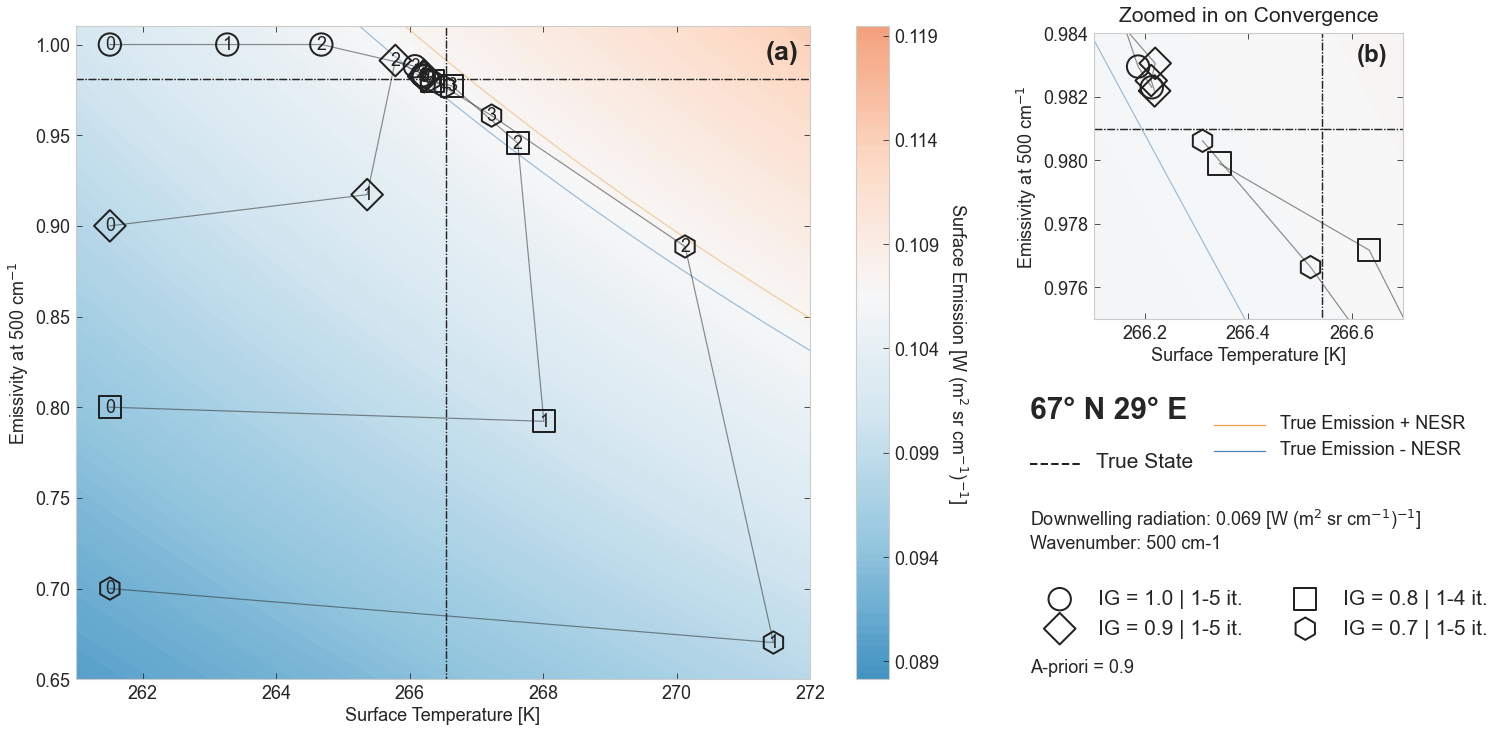

In [36]:
%matplotlib inline
fontsize=18
fig = plt.figure(figsize=(20,10))
gs1 = gridspec.GridSpec(1, 1)
ax0 = fig.add_subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs2[0])

cmap = 'PuOr_r'
cmap = 'RdBu_r'
cmap = truncate_colormap(plt.get_cmap('RdBu_r'), 0.2, 0.8)
color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a']

wn = 500
nesr = 0.0004
F_down = 0.069


case = '6729'
err = '1050_flat3'
folder = 'Final/EM_{}_emAP_f{}'.format(case,err)
ds_ref = nc.Dataset("OUTPUTS/{}/fe2es_sgm_ref_d0001_acq3.nc".format(folder))
true_em = ds_ref['emissivity1'][:][np.where(ds_ref['wn_emissivity'][:]==wn)][0]
true_Ts = ds_ref['Tskin'][:][30,30]

txts = ['IG = 1.0','IG = 0.9','IG = 0.8','IG = 0.7']
errs = ['1050_flatIG_flatAP4', '1050_flat4', '1050_flatIG2_flatAP4', '1050_flatIG3_flatAP4']
markers = ['o','D','s','h']
folders = ['Final/EM_{}_emAP_f{}'.format(case,err) for err in errs]
print(folders)
for xid, ax in enumerate([ax0,ax1]):
    true_rad = rad(true_em,true_Ts,F_down,wn,1)
    Ts = np.linspace(true_Ts-7,true_Ts+7,num=1000,endpoint=True)
    em = np.linspace(true_em-0.35,true_em+0.1,num=1000,endpoint=True)
    tt, ee = np.meshgrid(Ts, em, sparse=True)
    rads = rad(ee,tt,F_down,wn,1)
    cs = ax.contourf(Ts,em,rads,cmap=cmap,levels = np.linspace(rads.min(),rads.max(),num=100),norm=colors.CenteredNorm(vcenter=true_rad),alpha=1)
    if xid ==0 :
        cbar = fig.colorbar(cs, ax=ax)
        cbar.set_label('Surface Emission [W (m$^2$ sr cm$^{-1}$)$^{-1}$]',rotation=270,labelpad=30,fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize) 
        cbar.set_ticks(np.arange(0.089,0.124,0.005))
#     ax.contour(Ts,em,rads,levels=[true_rad-nesr,true_rad,true_rad+nesr], colors=['#f1a340','k','#998ec3'][::-1],alpha=0.5,linestyles='-')
    ax.contour(Ts,em,rads,levels=[true_rad-nesr,true_rad+nesr], colors=['#f1a340','steelblue'][::-1],alpha=0.5,linestyles='-')

    for j, folder in enumerate(folders):
        col = 'k'
        files = []
        for file in os.listdir("OUTPUTS/{}/".format(folder)):
            if file.endswith("L2M_OUT.nc"):
                files.append(file)
        files = sorted(files, key=lambda x: int(x.split('_L2M')[0]))
        files.append('fe2es_l2m_out_d0001.nc')
        Tss = []
        ems = []
        for i, file in enumerate(files):
            ds_l2m = nc.Dataset("OUTPUTS/{}/{}".format(folder,file))
            Tss.append(ds_l2m['TSKIN'][:])
            ems.append(ds_l2m['EMISS'][:][np.where(ds_l2m['egrid'][:]==wn)])
            if xid==0:
                ax.annotate(i, (ds_l2m['TSKIN'][:],ds_l2m['EMISS'][:][np.where(ds_l2m['egrid'][:]==wn)]),ha='center',va='center',fontsize=fontsize,color=col)
        ds_ref = nc.Dataset("OUTPUTS/{}/fe2es_sgm_ref_d0001_acq3.nc".format(folder))
        ax.hlines(ds_ref['emissivity1'][:][np.where(ds_ref['wn_emissivity'][:]==wn)],200,350,color='k',alpha=0.6,linestyle='-.')
        ax.vlines(ds_ref['Tskin'][:][30,30],0.5,1.5,color='k',alpha=0.6,linestyle='-.')
        ax.plot(Tss,ems,color=col,alpha=0.5)
        ax.scatter(Tss,ems,color='none',marker=markers[j],facecolors='none', edgecolors=col,linewidth=2,s=500,alpha=1,zorder=20,label='{} | 1-{} it.'.format(txts[j],ds_l2m['itcount'][:]))
    ax.set_ylabel('Emissivity at {}'.format(wn)+' cm$^{-1}$',fontsize=fontsize)
    ax.set_xlabel('Surface Temperature [K]',fontsize=fontsize)
    ax.grid(False)
    ax.tick_params(axis='x', which='both',bottom=True,top=True, labelsize=fontsize)
    ax.tick_params(axis='y', which='both', labelsize=fontsize)

ax0.set_ylim(0.65,1.01)
ax0.set_xlim(261,272)
ax1.set_ylim(0.975,0.984)
ax1.set_xlim(266.1,266.7)

fig.patch.set_alpha(1)

gs1.tight_layout(fig, rect=[0, 0, 0.7, 1])
gs2.tight_layout(fig, rect=[0.7, 0.5, 1, 1])

ax0.plot([1.3,1.37],[0.33,0.33],transform=ax0.transAxes,color='k',clip_on=False,linestyle='--',linewidth=2)
ax0.text(1.39,0.324,'True State',transform=ax0.transAxes,fontsize=fontsize+3)

# ['#f1a340','lightgrey','#998ec3'][::-1]
# ax0.plot([1.55,1.62],[0.43,0.43],transform=ax0.transAxes,color='k',clip_on=False,linestyle='-')
# ax0.text(1.64,0.424,'True Emission',transform=ax0.transAxes,fontsize=fontsize,color='k')
ax0.plot([1.55,1.62],[0.39,0.39],transform=ax0.transAxes,color='#f1a340',clip_on=False,linestyle='-')
ax0.text(1.64,0.384,'True Emission + NESR',transform=ax0.transAxes,fontsize=fontsize,color='k')
ax0.plot([1.55,1.62],[0.35,0.35],transform=ax0.transAxes,color='steelblue',clip_on=False,linestyle='-')
ax0.text(1.64,0.344,'True Emission - NESR',transform=ax0.transAxes,fontsize=fontsize,color='k')


ax0.text(0.94, 0.95, labels[0], fontweight='bold', color='k', transform=ax0.transAxes, fontsize=fontsize+9)
ax1.text(0.85, 0.9, '(b)', fontweight='bold', color='k',transform=ax1.transAxes, fontsize=fontsize+6)
ax1.set_title('Zoomed in on Convergence', color='k',fontsize=fontsize+3,y=1.02)

ax0.text(1.3,0.4,'{}° N {}° E'.format(case[0:2],case[2:]),transform=ax0.transAxes,fontsize=fontsize+12,fontweight='bold')
ax0.text(1.3,0.2,'Downwelling radiation: {}'.format(F_down)+' [W (m$^2$ sr cm$^{-1}$)$^{-1}$]'+'\nWavenumber: {} cm-1'.format(wn),transform=ax0.transAxes,fontsize=fontsize,ha='left')
ax0.text(1.3,0.01,'A-priori = 0.9',transform=ax0.transAxes,fontsize=fontsize,ha='left')

ax0.legend(bbox_to_anchor=(1.3,0.15),ncol=2, loc='upper left', borderaxespad=0., frameon=False,fontsize=fontsize+3)
fig.savefig('plots/fig10.pdf',bbox_inches='tight')
plt.show()

## Different case IGs

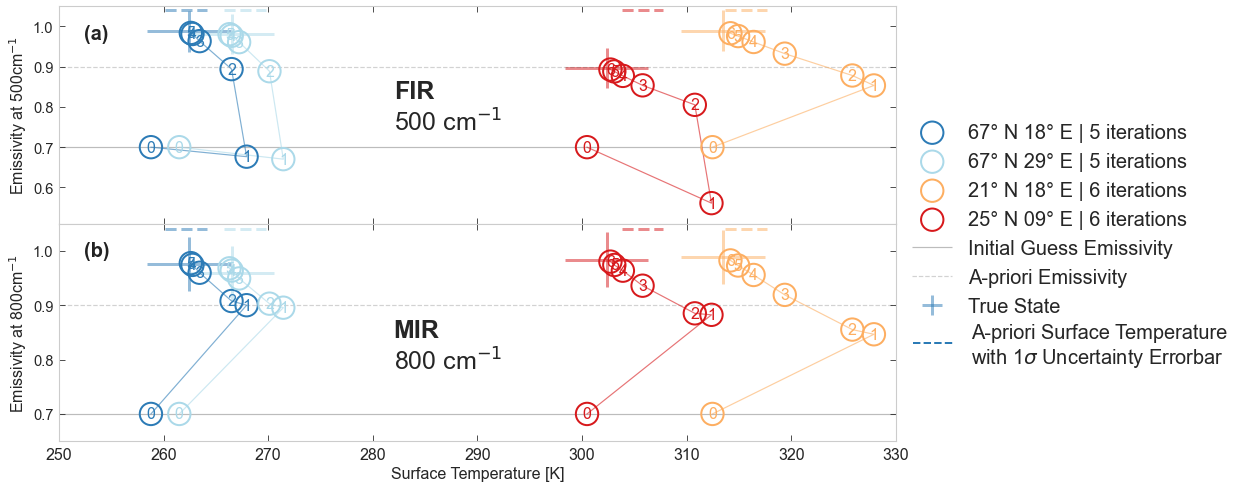

In [37]:
%matplotlib inline
fontsize=16
case = '6729'
wn = 500
wns = [500,800]
fig = plt.figure(figsize=(15,8))
cases = ['6718','6729','2118','2509']
color_list = ['#d7191c','#fdae61','#abd9e9','#2c7bb6'][::-1]
txts = ['{}° N {}° E'.format(case[0:2],case[2:4]) for case in cases]
Taptxts = ['_','_','_','_']
truetxts = ['True State','_','_','_']
err = '1050_flatIG3_flatAP4'
folders = ['Final/EM_{}_emAP_f{}'.format(case,err) for case in cases]
for iwn, wn in enumerate(wns):
    ax = fig.add_subplot(211+iwn)
    for j, folder in enumerate(folders):
        col = list(colors.TABLEAU_COLORS.values())[j]
        col = color_list[j]
        files = []
        for file in os.listdir("OUTPUTS/{}/".format(folder)):
            if file.endswith("L2M_OUT.nc"):
                files.append(file)
        files = sorted(files, key=lambda x: int(x.split('_L2M')[0]))
        files.append('fe2es_l2m_out_d0001.nc')
        Tss = []
        ems = []
        for i, file in enumerate(files):
            ds_l2m = nc.Dataset("OUTPUTS/{}/{}".format(folder,file))
            Tss.append(ds_l2m['TSKIN'][:])
            ems.append(ds_l2m['EMISS'][:][np.where(ds_l2m['egrid'][:]==wn)])
            ax.annotate(i, (ds_l2m['TSKIN'][:],ds_l2m['EMISS'][:][np.where(ds_l2m['egrid'][:]==wn)]),ha='center',va='center',fontsize=fontsize,color=col)
        ds_ref = nc.Dataset("OUTPUTS/{}/fe2es_sgm_ref_d0001_acq3.nc".format(folder))
        ax.errorbar(ds_ref['Tskin'][:][30,30],ds_ref['emissivity1'][:][np.where(ds_ref['wn_emissivity'][:]==wn)],xerr=4,yerr=0.05, marker='.',color=col,linewidth=3,alpha=0.5,label=truetxts[j],fmt='none')
        eb = ax.errorbar(ds_l2m['TSKIN_AP'][:],1.04,xerr=np.sqrt(ds_l2m['TSKIN_APCM'][:]),marker=None,color=col,linewidth=3,alpha=0.5,label=Taptxts[j],linestyle='--')
        eb[-1][0].set_linestyle('--')
        ax.plot(Tss,ems,color=col,alpha=0.6)
        ax.scatter(Tss,ems,color='none',marker='o',facecolors='none', edgecolors=col,linewidth=2,s=500,alpha=1,zorder=20,label='{} | {} iterations'.format(txts[j],ds_l2m['itcount'][:]))
    ax.grid(False)
    ax.set_ylabel('Emissivity at {}'.format(wn)+'cm$^{-1}$',fontsize=fontsize)
    ax.set_xlabel('Surface Temperature [K]',fontsize=fontsize)
    ax.set_ylim(0.51,1.05)
    ax.set_xlim(250,330)
    ax.text(0.4,0.58-0.1*iwn,['FIR','MIR'][iwn],transform=ax.transAxes,fontsize=25,fontweight='bold')
    ax.text(0.4,0.43-0.1*iwn,'{}'.format(wn)+' cm$^{-1}$',transform=ax.transAxes,fontsize=25)
    ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
    ax.hlines(0.7,100,400,color='k',alpha=0.3,linestyle='-',label='Initial Guess Emissivity')
    ax.hlines(0.9,100,400,color='k',alpha=0.2,linestyle='--',label='A-priori Emissivity')
    ax.text(0.03, 0.85, labels[iwn], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+4)
ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=True, labelsize=fontsize)
ax.set_ylim(0.65,1.05)

ax.plot([1.02,1.07],[0.45,0.45],transform=ax.transAxes,color=color_list[0],clip_on=False,linestyle='--',linewidth=2)
ax.text(1.09,0.36,'A-priori Surface Temperature\nwith 1$\sigma$ Uncertainty Errorbar',transform=ax.transAxes,fontsize=fontsize+4)

plt.legend(bbox_to_anchor=(1.01, 1.5),ncol=1, loc='upper left', borderaxespad=0., fontsize=fontsize+4,frameon=False)
fig.patch.set_alpha(1)
fig.subplots_adjust(hspace=0)
fig.savefig('plots/fig11.pdf',bbox_inches='tight')
plt.show()

# Appendix - A-priori error

In [38]:
def FIR_emiss_rms(ds_l2m,ds_ref,min_iq=1):
    
    rang = np.where((ds_l2m['egrid'][:]<=600) & (ds_l2m['egrid'][:]>=100))[0]

    # according to INFORMATION QUANTIFIER
    em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
    emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
    em_ap_vcm = ds_l2m['EMISS_APCM'][:]
    iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
    idc2 = np.where(iq[rang]>min_iq)
    
    rms2 = np.sqrt(np.sum(np.square(ds_l2m['EMISS'][:][idc2]-ds_ref['emissivity1'][:][10:-10][idc2]))/len(ds_l2m['EMISS'][:][idc2]))
    return rms2

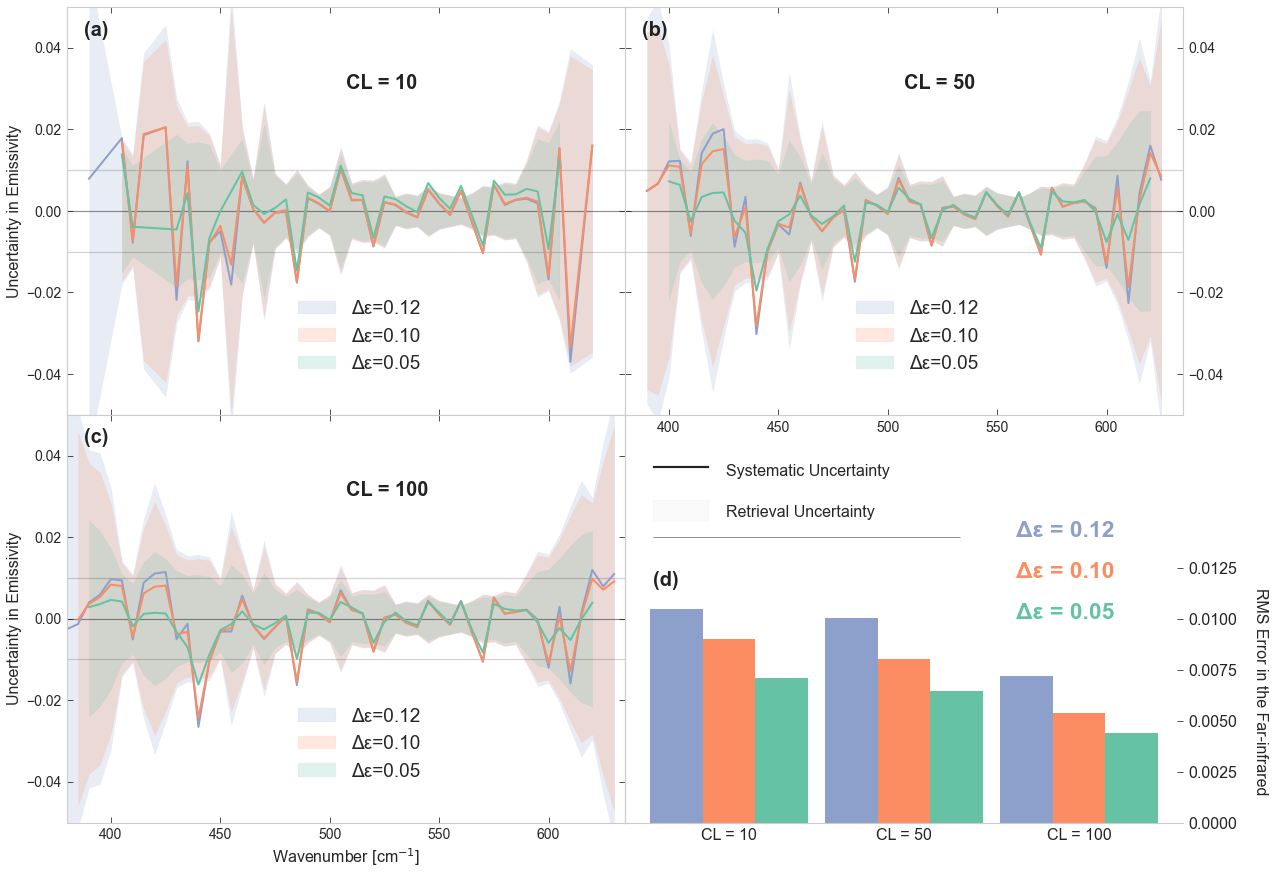

In [39]:
err_lists = [['1210','1010','0510'],['1250','1050','0550'],['12100','10100','05100']]
case = '6718'
fig, axs = plt.subplots(2,2,figsize=(20,15))
color_list = ['#66c2a5','#fc8d62','#8da0cb'][::-1]
labels = ['(a)','(b)','(c)','(d)']
for j, errs in enumerate(err_lists):
    ax = axs.flatten()[j]
    for i, err in enumerate(errs):
        ds_l2m = nc.Dataset('OUTPUTS/Final/EM_6718_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(err))
        ds_ref = nc.Dataset('OUTPUTS/Final/EM_6718_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(err))
        em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
        emerr = np.sqrt(ds_l2m['sx'][:][em_idc[0],em_idc[0]])
        emvar = ds_l2m['sx'][:][em_idc[0],em_idc[0]]
        em_ap_vcm = ds_l2m['EMISS_APCM'][:]
        iq = -0.5*np.log2(np.divide(emvar,em_ap_vcm.diagonal()))
        idc = np.where(iq>1)
        win1 = np.where((ds_l2m['egrid'][:]<=650)&(iq>1))
        win2 = np.where((ds_l2m['egrid'][:]>=650)&(iq>1))
        windows = [win1]
        col = list(colors.TABLEAU_COLORS.values())[i]
        col = color_list[i]
        for win in windows:
            ax.plot(ds_l2m['egrid'][win], ds_l2m['EMISS'][win][:]-ds_ref['emissivity1'][:][10:-10][win], color=col,linewidth=2)
            ax.fill_between(ds_l2m['egrid'][win], emerr[win],-emerr[win],color=col,alpha=0.2,label='Δε=0.{}'.format(err[:2]))
        ax.set_ylim(-0.05,0.05)
    ax.tick_params(axis='y', which='both', labelleft=True,labelright=False,labelsize=fontsize-2)
    ax.tick_params(axis='x', which='both', labelsize=fontsize-2)

    if j == 1:
        ax.tick_params(axis='y', which='both', labelleft=False,labelright=True,labelsize=fontsize-2)
    if j == 2:
        ax.set_xlabel('Wavenumber [cm$^{-1}$]',fontsize=fontsize)
    ax.text(0.5, 0.8, 'CL = {}'.format(err[2:]), fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+4)
    ax.text(0.03, 0.93, labels[j], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+4)
    ax.set_xlim(380,635)
    ax.hlines(0,100,1600, linestyle='-',color='k',alpha=0.5)
    ax.hlines([-0.01,0.01],100,1600, linestyle='-',color='k',alpha=0.2)
    ax.grid(False)
    ax.legend(bbox_to_anchor=(0.4, 0.3), loc='upper left', borderaxespad=0.,fontsize=fontsize+3,frameon=False)   
    if j != 1:
        ax.set_ylabel('Uncertainty in Emissivity', fontsize=fontsize)
    
    
# ax.text(1.05, 0.8, '- Systematic uncertainty \n- - - Retrieval uncertainty'.format(err[2:]), color='k', transform=ax.transAxes, fontsize=fontsize)
err_lists = [['1210','1010','0510'][::-1],['1250','1050','0550'][::-1],['12100','10100','05100'][::-1]]
color_list = color_list
ax = axs[1,1]
for i, errs in enumerate(err_lists):
    y = []
    x = np.arange(len(errs))[::-1]
    for err in errs:
        ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
        ds_ref = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_sgm_ref_d0001_acq3.nc'.format(case,err))
        rms2 = FIR_emiss_rms(ds_l2m,ds_ref,1)
        y.append(rms2)
    width =0.3
    col = color_list[i]
    rects = ax.bar(x-width+width*i, y,width=width, label=errs, color=col)
ax.set_xticks(x)
ax.set_yticks(np.arange(0,0.015,0.0025))
ax.set_xticklabels(['CL = 10','CL = 50','CL = 100'][::-1], fontsize=15)
ax.grid(False)
ax.set_ylim(0,0.02)
ax.tick_params(axis='y', which='both',left=False,labelleft=False, labelright=True,labelsize=fontsize)
ax.tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=True, labelsize=fontsize)
ax.patch.set_alpha(0)
for i, err in enumerate(errs):
    ax.text(0.7, 0.5+i*0.1, 'Δε = 0.{}'.format(err[:2]), fontweight='bold', color=color_list[::-1][i], transform=ax.transAxes, fontsize=fontsize+7,zorder=50)
y1 = 0.85
y2 = 0.75
leg_rect1 = mpl.patches.Rectangle((0.05,y1+0.02), 0.1, 0.005, transform=ax.transAxes,color='k',alpha=1,clip_on=False)
ax.add_patch(leg_rect1)
ax.text(0.18,y1,'Systematic Uncertainty',transform=ax.transAxes,fontsize=fontsize)
leg_rect2 = mpl.patches.Rectangle((0.05,y2-0.01), 0.1, 0.05, transform=ax.transAxes,fill=True,alpha=0.1,edgecolor='k',clip_on=False)
ax.add_patch(leg_rect2)
ax.text(0.18,y2,'Retrieval Uncertainty',transform=ax.transAxes,fontsize=fontsize)
ax.set_ylabel('RMS Error in the Far-infrared',rotation=270,labelpad=30,fontsize=fontsize,y=0.32)
ax.yaxis.set_label_position("right")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.text(0.05, 0.58, labels[3], fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+4)
ax.hlines(0.7,0.05,0.6,color='k', transform=ax.transAxes,linewidth=1,alpha=0.5)
# ax.grid(axis='y',zorder=0)

fig.subplots_adjust(wspace=0,hspace=0)
fig.patch.set_alpha(1)
fig.savefig('plots/fig12.pdf',bbox_inches='tight')
plt.show()

In [40]:
def new_single_cmap(RGB1):
    N = 256
    col1 = np.ones((N, 4))
    col1[:, 0] = np.linspace(RGB1[0]/256, 1, N)
    col1[:, 1] = np.linspace(RGB1[1]/256, 1, N)
    col1[:, 2] = np.linspace(RGB1[2]/256, 1, N)
    col1_cmp = ListedColormap(col1[::-1])
    return col1_cmp

def new_double_cmap(RGB1,RGB2):
    N = 256
    col1 = np.ones((N, 4))
    col1[:, 0] = np.linspace(RGB1[0]/256, 1, N)
    col1[:, 1] = np.linspace(RGB1[1]/256, 1, N)
    col1[:, 2] = np.linspace(RGB1[2]/256, 1, N)
    col1_cmp = ListedColormap(col1)

    col2 = np.ones((N, 4))
    col2[:, 0] = np.linspace(RGB2[0]/256, 1, N)
    col2[:, 1] = np.linspace(RGB2[1]/256, 1, N)
    col2[:, 2] = np.linspace(RGB2[2]/256, 1, N)
    col2_cmp = ListedColormap(col2)
    
    newcolors2 = np.vstack((col2_cmp(np.linspace(0, 1, 128)),col1_cmp(np.linspace(1, 0, 128))))
    double = ListedColormap(newcolors2, name='double')
    return double

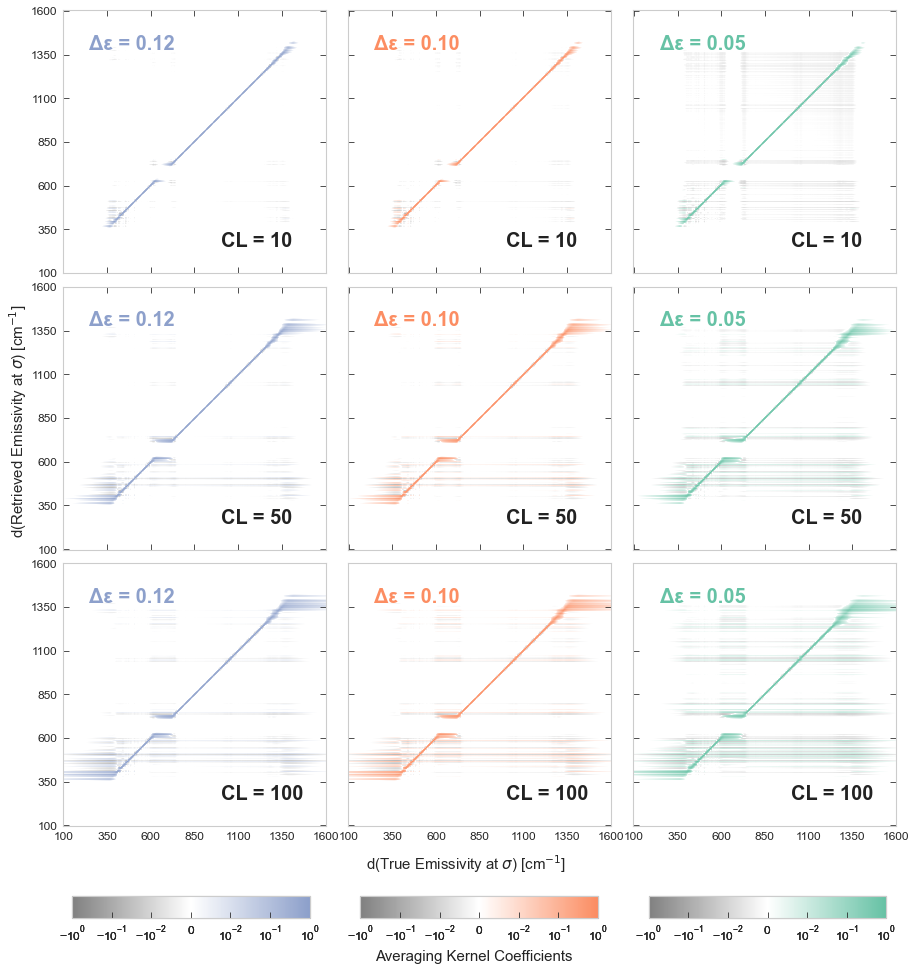

In [41]:
err_lists = [['1210','1010','0510'],['1250','1050','0550'],['12100','10100','05100']]
color_list = ['#66c2a5','#fc8d62','#8da0cb'][::-1]
rgb_color_list = [[102,194,165],[252,141,98],[141,160,203]][::-1]
case = '6718'
fontsize=15
gridspec = {'height_ratios': [1, 1, 1,0.1]}
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for j, errs in enumerate(err_lists):
    for i, err in enumerate(errs):
        ax = axs[j,i]
        ds_l2m = nc.Dataset('OUTPUTS/Final/EM_{}_emAP_f{}/fe2es_l2m_out_d0001.nc'.format(case,err))
        em_idc = np.where(ds_l2m['rv_idx'][:][0]==2)
        ak_em = ds_l2m['ak'][:][:,em_idc[0]][em_idc[0],:]
        ak_em=np.flip(ak_em,axis=0)
        
        cmap = new_double_cmap(rgb_color_list[i],[128,128,128])
        
        cs = ax.imshow(ak_em,cmap=cmap, norm=colors.SymLogNorm(linthresh=1e-3, linscale=1e-3,vmin=-1, vmax=1.0))
        ax.set_xticks(np.arange(0,301)[::50])
        ax.set_xticklabels(['{:.0f}'.format(wn) for wn in ds_l2m['egrid'][:][::50]],fontsize=fontsize+3)
        ax.set_yticks(np.arange(0,301)[::50])
        ax.set_yticklabels(['{:.0f}'.format(wn) for wn in ds_l2m['egrid'][:][::50][::-1]],fontsize=fontsize+3)
        col = color_list[i]
        ax.text(0.1, 0.85, 'Δε = 0.{}'.format(err[:2]), fontweight='bold', color=col, transform=ax.transAxes, fontsize=fontsize+5)
        ax.text(0.6, 0.1, 'CL = {}'.format(err[2:]), fontweight='bold', color='k', transform=ax.transAxes, fontsize=fontsize+5)
        ax.grid(False)
        
        ax.tick_params(axis='y', which='both',labelleft=False, labelright=False,labelsize=fontsize-3)
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize-3)
        
        if i == 0:
            ax.tick_params(axis='y', which='both',labelleft=True, labelright=False,labelsize=fontsize-3)
        if j == 2:
            ax.tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=True, labelsize=fontsize-3)
        
        cax = fig.add_axes([0.135+i*0.267,0.04,0.22,0.02])
        cb = plt.colorbar(cs,cax=cax,orientation='horizontal')
        cb.ax.tick_params(labelsize=fontsize-3)
        cb.set_ticks([-1,-0.1,-0.01,0,0.01,0.1,1])
cax.text(-1.15,-2.0,'Averaging Kernel Coefficients',color='k', transform=cax.transAxes, fontsize=fontsize)
fig.supylabel('d(Retrieved Emissivity at $\sigma$) [cm$^{-1}$]',fontsize=fontsize,x=0.075)
fig.supxlabel('d(True Emissivity at $\sigma$) [cm$^{-1}$]',fontsize=fontsize,y=0.08)
fig.subplots_adjust(wspace=0.07,hspace=0.05)
fig.savefig('plots/fig13.pdf',bbox_inches='tight')
fig.patch.set_alpha(1)
plt.show()